In [121]:
from functools import partial, wraps
from time import time as tic
from pathlib import Path
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from randomgen import RandomGenerator, Xoroshiro128
from scipy.signal import savgol_filter
from scipy.stats import rv_discrete

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext cython
pd.options.display.max_rows = 5

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [122]:
import pycorrelate as pyc
pyc.__version__

'0.3'

In [123]:
import loader

In [124]:
# importlib.reload(depi.depi)
# importlib.reload(depi)
# importlib.reload(depi.loss)
# importlib.reload(loss)

In [125]:
import depi
from depi import fret
from depi import dist_distrib as dd
from depi import plotter as pl
from depi import bva
from depi import loss
from depi import tcspc
depi.__version__

'0.1+10.gc0fa55c'

In [126]:
print([x for x in dir(depi) if not x.startswith('__')])

['_version', 'bva', 'ctmc', 'depi', 'depi_cy', 'dist_distrib', 'fret', 'load_params', 'loader', 'loss', 'mem', 'plotter', 'recolor_burstsph', 'recolor_burstsph_cache', 'save_params', 'tcspc', 'validate_params']


In [127]:
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.callbacks import CheckpointSaver
skopt.__version__

'0.5.2'

# Load data

### Measurement grouped by name

In [128]:
folder = Path('../Relevant BH measurements/dsDNA/results')

In [129]:
[f.name for f in folder.glob("*.csv")
 if 'merge' in f.stem]

['d17_merge_Donly_bursts.csv',
 'd17_merge_Donly_burst_photons.csv',
 'd17_merge_FRET_bursts.csv',
 'd17_merge_FRET_burst_photons.csv',
 'd7+d17_merge_Donly_bursts.csv',
 'd7+d17_merge_Donly_burst_photons.csv',
 'd7+d17_merge_FRET_bursts.csv',
 'd7+d17_merge_FRET_burst_photons.csv',
 'd7_merge_Donly_bursts.csv',
 'd7_merge_Donly_burst_photons.csv',
 'd7_merge_FRET_bursts.csv',
 'd7_merge_FRET_burst_photons.csv']

In [130]:
name = 'd7'
#name = 'd17'
#name = 'd7+d17'
bursts, burstsph, meta = depi.loader.load_burst_and_ph_data(name, folder, pop='FRET')
burstsph['nanot'] = burstsph.nanotime * meta['nanotime_unit'] * 1e9

burstsD, burstsphD, _ = depi.loader.load_burst_and_ph_data(name, folder, pop='Donly')
burstsphD['nanot'] = burstsphD.nanotime * meta['nanotime_unit'] * 1e9
label = f'Sample {name}'

- Loaded photon-data "../Relevant BH measurements/dsDNA/results/d7_merge_FRET_burst_photons.csv"
../Relevant BH measurements/dsDNA/results/d7_merge_FRET_bursts.csv
- Loaded burst data "../Relevant BH measurements/dsDNA/results/d7_merge_FRET_bursts.csv"
- Loaded photon-data "../Relevant BH measurements/dsDNA/results/d7_merge_Donly_burst_photons.csv"
../Relevant BH measurements/dsDNA/results/d7_merge_Donly_bursts.csv
- Loaded burst data "../Relevant BH measurements/dsDNA/results/d7_merge_Donly_bursts.csv"


In [131]:
burstsph.groupby('stream').size()

stream
DexDem    26228
DexAem    37281
AexDem      767
AexAem    58932
dtype: int64

### Setup

In [151]:
ns = 1.0
nm = 1.0
time = 'ns' if ns == 1 else 's' if ns == 1e-9 else '?'
space = 'nm' if nm == 1 else 'm' if nm == 1e-9 else '?'
#ts_unit = meta['timestamp_unit']
#ts_unit = int(ts_unit * 1e9) if time == 'ns' else ts_unit
#ts_unit

In [152]:
bursts.shape

(1482, 21)

In [153]:
burstsph.shape

(123208, 5)

In [154]:
print('First timestamps in seconds:')
burstsph.timestamp.iloc[:2] * 1e-9

First timestamps in seconds:


burst  ph
0      0     0.102994
       1     0.103160
Name: timestamp, dtype: float64

In [155]:
print('Last timestamps in seconds:')
burstsph.timestamp.iloc[-2:] * 1e-9

Last timestamps in seconds:


burst  ph
1481   53    2969.039465
       54    2969.039541
Name: timestamp, dtype: float64

# IRFs

In [156]:
dd_irf_fname = folder / 'IRF_DD.csv'
assert dd_irf_fname.is_file()

da_irf_fname = folder / 'IRF_DA.csv'
assert da_irf_fname.is_file()

aa_irf_fname = folder / 'IRF_AA.csv'
assert aa_irf_fname.is_file()

In [157]:
DD_decay_minbin = 1778
DD_decay_maxbin = 2585
irf = pd.read_csv(dd_irf_fname, header=None, index_col=0)
irf.index.name = 'time'
irf.columns = ['DD']
irf['DA'] = pd.read_csv(da_irf_fname, header=None, index_col=0)
irf = irf.iloc[DD_decay_minbin:DD_decay_maxbin]

irf_AA = pd.read_csv(aa_irf_fname, header=None, index_col=0)
irf_AA.index.name = 'time'
irf_AA.columns = ['AA']
#irf = irf.iloc[DD_decay_minbin:DD_decay_maxbin]

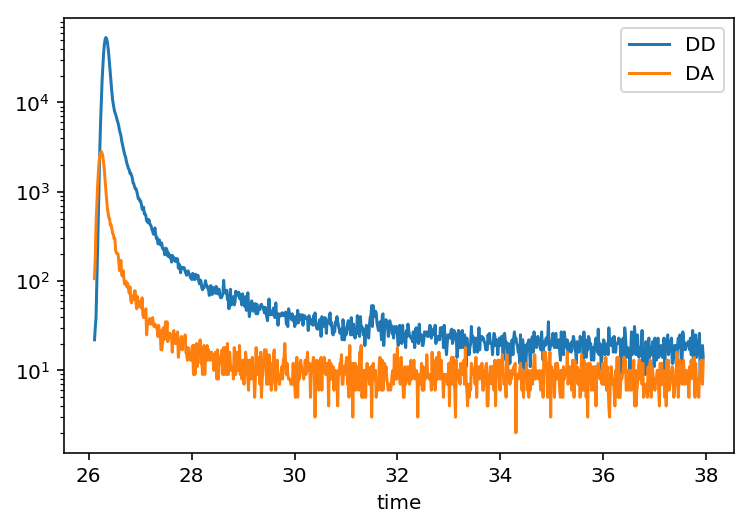

In [158]:
irf.plot()
plt.yscale('log')

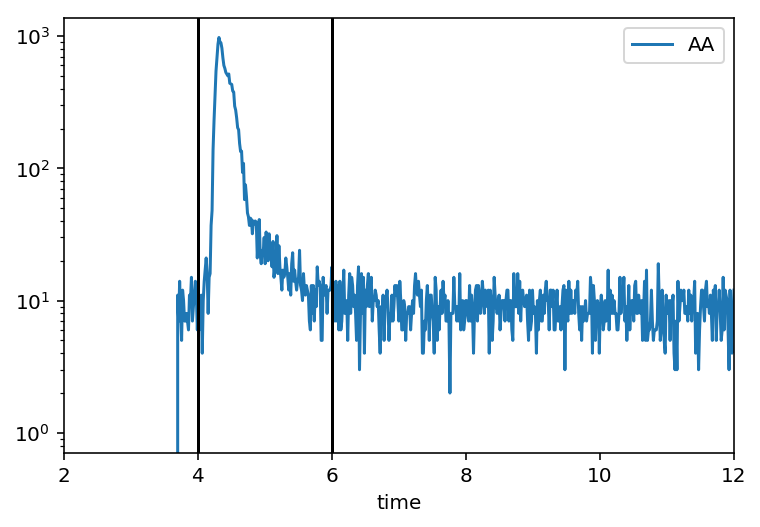

In [159]:
irf_AA.plot()
plt.yscale('log')
plt.xlim(2, 12)
plt.axvline(4, color='k')
plt.axvline(6, color='k')

In [160]:
kws = dict(window_length=9, polyorder=3, mode='nearest')
irf['DD_smooth'] = savgol_filter(irf.DD, **kws)
irf['DA_smooth'] = savgol_filter(irf.DA, **kws)
irf.loc[30:, 'DD_smooth'] = np.nan
irf.loc[28.9:, 'DA_smooth'] = np.nan
irf.iloc[:5, 2] = irf.DD.iloc[:5]

irf_AA['AA_smooth'] = savgol_filter(irf_AA.AA, **kws)
irf_AA = irf_AA.loc[4:6]

In [161]:
irf.DD_smooth.min(), irf.DA_smooth.min(), irf_AA.AA_smooth.min()

(22.0, 10.095238095238079, 6.991341991341979)

In [162]:
irf.DD_smooth -= irf.DD_smooth.min() - 1
irf.DA_smooth -= irf.DA_smooth.min() - 1
irf.head(3)

,DD,DA,DD_smooth,DA_smooth
time,,,,
26.112577,22,107,1.0,113.350649
26.127255,30,181,9.0,213.969697
26.141933,39,420,18.0,408.125541


In [163]:
irf_AA.AA_smooth -= irf_AA.AA_smooth.min() - 1
irf_AA.head(3)

,AA,AA_smooth
time,,
4.007158,11,2.813853
4.021836,6,1.346320
4.036514,7,1.000000


In [164]:
tcspc_unit = meta['nanotime_unit']
tcspc_unit

1.4678233e-11

In [165]:
irf['DD_pdf'] = irf.DD_smooth / (irf.DD_smooth.sum() * tcspc_unit * 1e9)
irf['DA_pdf'] = irf.DA_smooth / (irf.DA_smooth.sum() * tcspc_unit * 1e9)
irf_AA['AA_pdf'] = irf_AA.AA_smooth / (irf_AA.AA_smooth.sum() * tcspc_unit * 1e9)

In [166]:
irf['DD_smooth1'] = irf.DD_smooth / irf.DD_smooth.sum() 
irf['DA_smooth1'] = irf.DA_smooth / irf.DA_smooth.sum()
irf_AA['AA_smooth1'] = irf_AA.AA_smooth / irf_AA.AA_smooth.sum()

In [167]:
# Makes sure there are no negative values
for c in irf.columns:
    assert ((irf[c] > 0) | (pd.isnull(irf[c]))).all(), c

In [168]:
# Makes sure there are no negative values
for c in irf_AA.columns:
    assert ((irf_AA[c] > 0) | (pd.isnull(irf_AA[c]))).all(), c

In [169]:
(np.trapz(irf.loc[~pd.isnull(irf.DD_pdf), 'DD_pdf'].values, irf.loc[~pd.isnull(irf.DD_pdf)].index),
 np.trapz(irf.loc[~pd.isnull(irf.DA_pdf), 'DA_pdf'].values, irf.loc[~pd.isnull(irf.DA_pdf)].index),
 np.trapz(irf_AA.loc[~pd.isnull(irf_AA.AA_pdf), 'AA_pdf'].values, irf_AA.loc[~pd.isnull(irf_AA.AA_pdf)].index))

(0.9999870220572316, 0.9983776523881848, 0.9996354813768693)

/opt/conda/miniconda3/envs/py36-sys/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


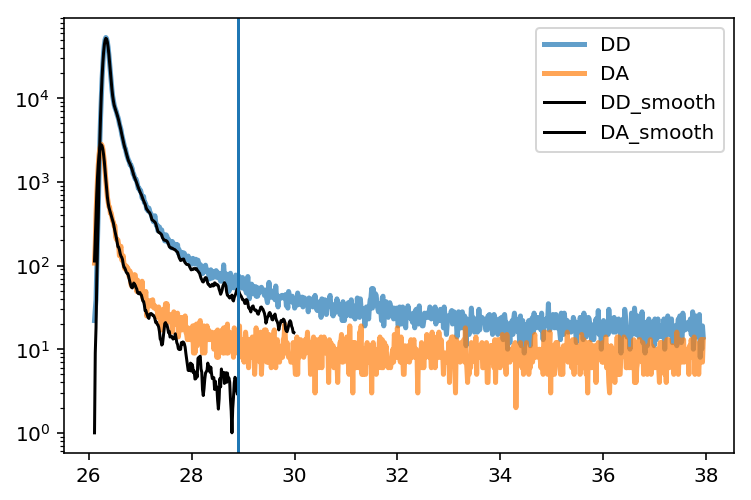

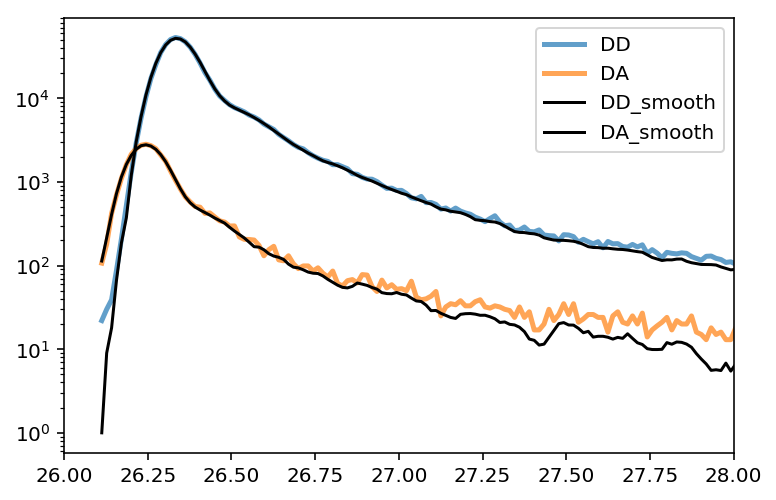

In [170]:
fig = plt.figure()
plt.semilogy(irf.DD, lw=2.5, alpha=0.7)
plt.semilogy(irf.DA, lw=2.5, alpha=0.7)
plt.semilogy(irf.DD_smooth, color='k') 
plt.semilogy(irf.DA_smooth, color='k')
plt.legend()
plt.axvline(28.9)
display(fig)
plt.xlim(26, 28);

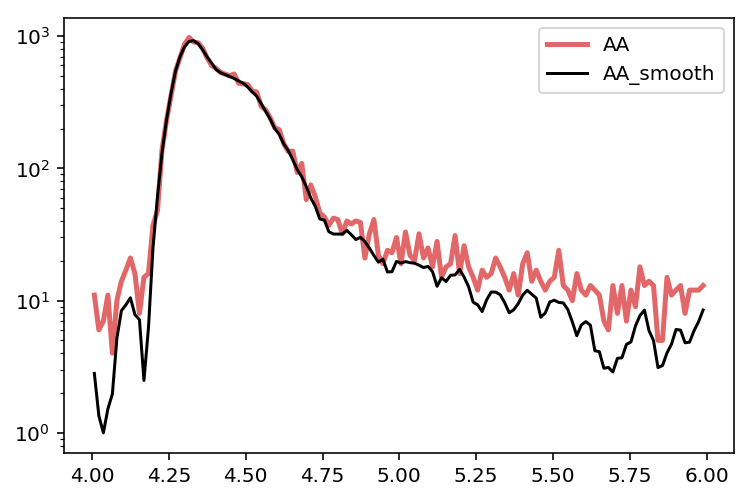

In [171]:
fig = plt.figure()
plt.semilogy(irf_AA.AA, lw=2.5, color='C3', alpha=0.7)
plt.semilogy(irf_AA.AA_smooth, color='k') 
plt.legend();

# FRET population

## Filter `bursts` DataFrame

In [172]:
th = 25
selection = (bursts.nd + bursts.na > th) & (bursts.naa > th)
bursts_sel = bursts.loc[selection]
bursts_sel.head()

,E,S,bg_aa,bg_ad,bg_da,bg_dd,bg_period,max_rate,na,naa,...,nda,nt,size_raw,t_start,t_stop,width_ms,spot,repeat,istart,istop
burst,,,,,,,,,,,,,,,,,,,,,
0,0.900993,0.478629,3.049899,1.993348,0.373667,3.823604,0,103562.546643,38.006652,45.950101,...,-0.373667,88.133149,97,0.103192,0.107438,4.24630,0,1,0,97
3,0.815541,0.468268,6.362929,4.158672,0.779573,7.977090,0,66060.118022,70.841328,98.637071,...,-0.779573,185.501309,204,3.886852,3.895711,8.85895,0,1,210,414
4,0.804947,0.561050,3.767394,2.462287,0.461573,4.723114,0,73715.850130,46.537713,45.232606,...,0.538427,103.047206,115,3.953498,3.958743,5.24525,0,1,414,529
5,0.751427,0.548470,4.298862,2.809643,0.526688,5.389406,0,91639.154438,47.190357,51.701138,...,-0.526688,114.502090,127,5.389936,5.395921,5.98520,0,1,529,656
6,0.825775,0.512586,3.429458,2.241419,0.420170,4.299450,0,64104.946007,31.758581,36.570542,...,-0.420170,75.029674,85,7.976187,7.980961,4.77475,0,1,656,741


In [173]:
bursts_sel.width_ms.sum()

3638.9785500000007

In [174]:
burstsph.shape

(123208, 5)

## Filter `burstsph` DataFrame

In [175]:
th = 25
bsel = np.where((bursts.nd + bursts.na > th) & (bursts.naa > th))[0]
burstsph_sel = burstsph.loc[bsel]
burstsph_sel.shape

(87090, 5)

In [176]:
def bwidth(x, unit=1e-9):
    ts = x.timestamp.values
    width = (ts[-1] - ts[0]) * unit
    return width
assert all(burstsph_sel.groupby('burst').size() == bursts_sel.size_raw)
assert np.allclose(burstsph_sel.groupby('burst').apply(bwidth).sum(), 
                   bursts_sel.width_ms.sum() * 1e-3)

In [177]:
burstsph_sel.groupby('stream').size()

stream
DexDem    17507
DexAem    27033
AexDem      537
AexAem    42013
dtype: int64

# Intra-lifetime diffusion recolor

# Simulations

Selection of photons in `burstsph` detected in the D-excitation period:

In [178]:
Dex = (burstsph_sel.stream == 'DexDem')|(burstsph_sel.stream ==  'DexAem')

## Physical parameters

In [179]:
area1 = 4.015900 * 538.470302
area2 = 0.374247 * 380.683752

amp1 = 538.470302 / (538.470302 + 380.683752)
amp2 = 380.683752 / (538.470302 + 380.683752)

τ_A = 4.050585 * ns
τ_D = [4.015900 * ns, 0.374247 * ns]
D_fract = [area1 / (area1 + area2),  area2 / (area1 + area2)]

τ_D_mean = (τ_D[0]*D_fract[0]+τ_D[1]*D_fract[1])/(D_fract[0]+D_fract[1])
τ_D_mean2 = (τ_D[0]**2*D_fract[0]+τ_D[1]**2*D_fract[1])/(τ_D[0]*D_fract[0]+τ_D[1]*D_fract[1])

In [180]:
BG_d = (3300 - 1750 + 1) * 0.74486501 / (bursts_sel.width_ms.sum() * 1e-3)

In [181]:
BG_a = (3300 - 1750 + 1) * 1.428463 / (bursts_sel.width_ms.sum() * 1e-3)

In [182]:
frac=0.5
taurel = 2e6 * ns
k_s = [1/((1/frac)*taurel), 1/((1/(1-frac))*taurel)]
K = [[-k_s[0], k_s[0]],
     [k_s[1], -k_s[1]]]

## Simulation conditions

In [183]:
# depi.save_params('results/wlc_1s_D_B.json', params)

In [285]:
params, _, _ = depi.load_params('results/G_1s_D_B_opt_E_nanot_820')
params

{'D_fract': [0.9381886541859179, 0.06181134581408213],
 'R0': 5.54919485935689,
 'R_mean': 3.0,
 'R_sigma': 1.9,
 'bg_rate_a': 608.8373653645194,
 'bg_rate_d': 317.47525154002346,
 'dir_ex_t': 0.06,
 'dr': 0.0001,
 'du': 0.001,
 'gamma': 0.78,
 'lk': 0.055,
 'name': 'gaussian',
 'ndt': 10,
 'prob_A_dark': 0.021370326320928012,
 'tcspc_range': 22.765939383,
 'ts_unit': 1e-09,
 'u_max': 6,
 'α': 0.1,
 'δt': 0.014678232999999999,
 'τ_A': 4.050585,
 'τ_A_dark': 4000000.0,
 'τ_D': [4.0159, 0.374247],
 'τ_relax': 2.0}

In [286]:
rg = RandomGenerator(Xoroshiro128(1))
burstsph_sim = depi.recolor_burstsph(burstsph_sel.loc[Dex, 'timestamp'], rg=rg, **params)

In [186]:
# burstsph_sim = depi.recolor_burstsph_cache(burstsph_sel.loc[Dex, 'timestamp'], 
#                                            **params)

In [287]:
burstsph_sim

timestamp   nanotime      R_ph   A_ch  leak_ph  dir_ex_ph  \
burst ph                                                                  
0     0       102993700   1.278266  4.520295  False    False      False   
      1       103160300   1.680683 -0.134371   True    False      False   
...                 ...        ...       ...    ...      ...        ...   
1480  90  2967025133000   1.569513  4.472337  False    False      False   
      91  2967025137400  17.939150  3.174518  False    False      False   

          A_dark_ph  bg_ph  stream  
burst ph                            
0     0       False   True  DexDem  
      1       False  False  DexAem  
...             ...    ...     ...  
1480  90       True  False  DexDem  
      91       True  False  DexDem  

[44540 rows x 9 columns]

## Nanotime loss

In [288]:
import importlib
importlib.reload(loss)

<module 'depi.loss' from '/opt/src/depi/depi/loss.py'>

In [289]:
offset_Dex = tcspc.decay_hist_offset(burstsph_sel.loc[Dex, 'nanotime'], 
                                     tcspc_unit, 4095, rebin=4) * 1e9
offset_Dex

26.252463874524494

In [290]:
u = 1 / (tcspc_unit * 1e9)
nt_bins = np.arange(-2*u, 22*u, 2)
nanot_hist_d_exp, nanot_hist_a_exp = loss.nanot_hist_from_burstph(
    burstsph_sel, nt_bins, offset=offset_Dex / (1e9*tcspc_unit))

In [291]:
burstsph_sim = loss.add_irf_nanot(burstsph_sim, irf)

In [292]:
burstsph_sim['nanotime_conv_unit'] = (
    (burstsph_sim.nanotime_conv * (1e-9 / tcspc_unit))
     .round()
     .astype('int'))

In [293]:
offset_Dex_sim = tcspc.decay_hist_offset(burstsph_sim.nanotime_conv_unit, 
                                         tcspc_unit, 4095, rebin=4) * 1e9
offset_Dex_sim

0.17032866210416667

In [294]:
nanot_hist_d_sim, nanot_hist_a_sim = loss.nanot_hist_from_burstph(
    burstsph_sim, nt_bins, col='nanotime_conv_unit',
    offset=offset_Dex_sim / (1e9*tcspc_unit))

In [295]:
nanot_hist_d_sim = nanot_hist_d_sim * nanot_hist_d_exp.sum() / nanot_hist_d_sim.sum()
nanot_hist_a_sim = nanot_hist_a_sim * nanot_hist_a_exp.sum() / nanot_hist_a_sim.sum()
residuals_d = nanot_hist_d_exp - nanot_hist_d_sim
residuals_a = nanot_hist_a_exp - nanot_hist_a_sim

In [296]:
ll0_d = loss.loglike_metric(nanot_hist_d_exp, nanot_hist_d_exp)
ll0_a = loss.loglike_metric(nanot_hist_a_exp, nanot_hist_a_exp)
loglike_d = loss.loglike_metric(nanot_hist_d_sim, nanot_hist_d_exp) - ll0_d
loglike_a = loss.loglike_metric(nanot_hist_a_sim, nanot_hist_a_exp) - ll0_a
loglike_d, loglike_a

(713.6258338007028, 936.6143262804108)

In [297]:
loglike_tot, loglike_d, loglike_a = loss.iloss_loglike_nanot(
    burstsph_sim, irf, nt_bins, tcspc_unit, 
    nanot_hist_d_exp, nanot_hist_a_exp, 
    loglike_d_std=1, loglike_a_std=1, return_da_losses=True)
loglike_d, loglike_a

(713.6258338007028, 936.6143262804108)

In [298]:
nanot_hist_d_sim2, nanot_hist_a_sim2 = loss.calc_nanot_hist_irf_da(
        burstsph_sim, irf, nt_bins, tcspc_unit, nanot_hist_d_exp, nanot_hist_a_exp)

In [299]:
assert (nanot_hist_d_sim2 == nanot_hist_d_sim).all()
assert (nanot_hist_a_sim2 == nanot_hist_a_sim).all()

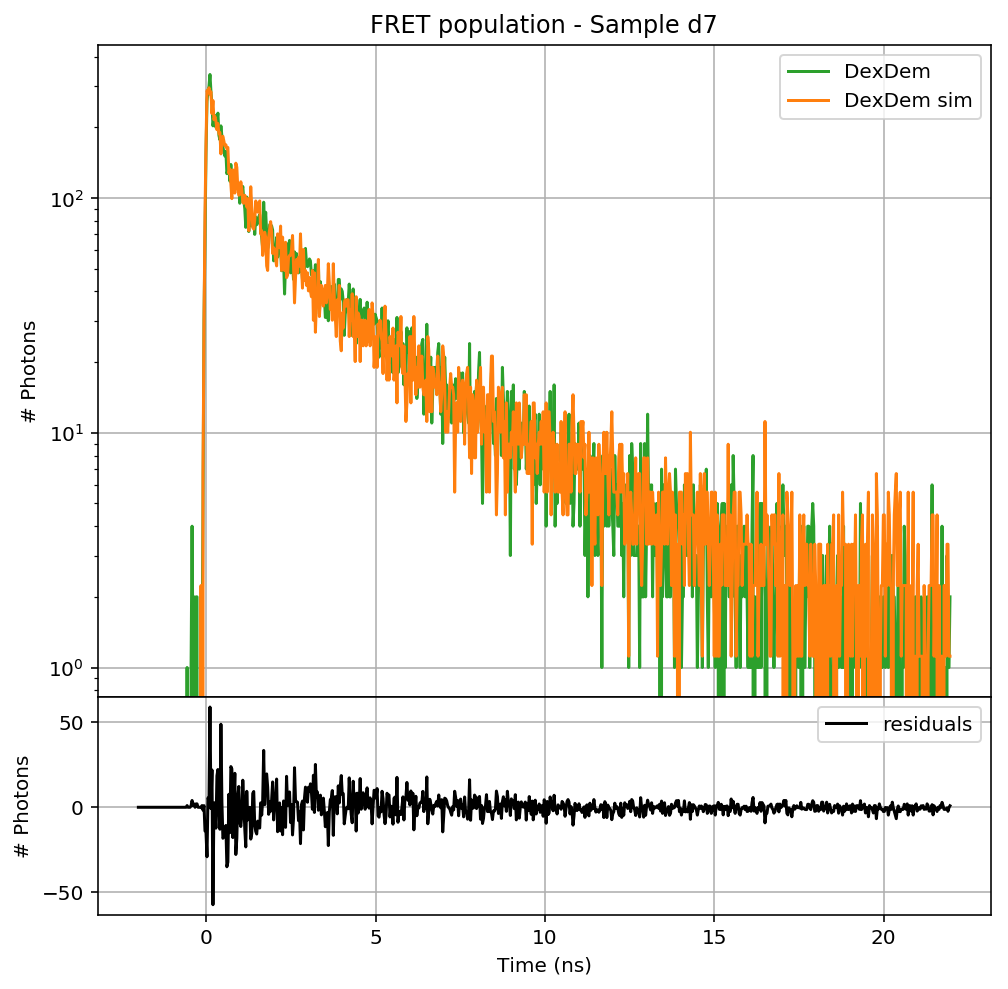

In [300]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3,1]})
plt.subplots_adjust(hspace=0)
time_axis = nt_bins[:-1] * meta['nanotime_unit'] * 1e9
ax[0].plot(time_axis, nanot_hist_d_exp, color='C2', label='DexDem')
ax[0].plot(time_axis, nanot_hist_d_sim, color='C1', label='DexDem sim')
ax[1].plot(time_axis, residuals_d, color='k', label='residuals')
ax[0].set_yscale('log')
for a in ax:
    a.grid(True)
    a.legend();
    a.set_ylabel('# Photons');
ax[1].set_xlabel('Time (ns)');
ax[0].set_title(f'FRET population - {label}');

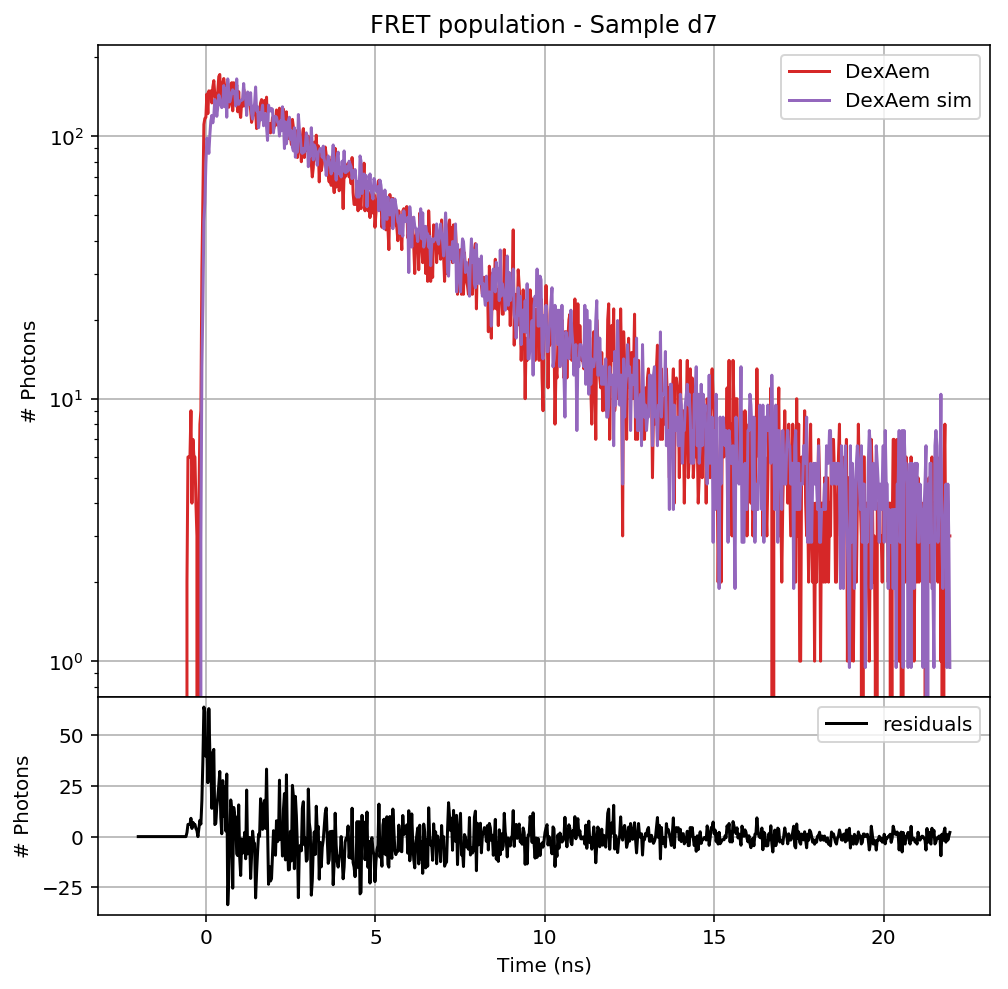

In [301]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
time_axis = nt_bins[:-1] * meta['nanotime_unit'] * 1e9
ax[0].plot(time_axis, nanot_hist_a_exp, color='C3', label='DexAem')
ax[0].plot(time_axis, nanot_hist_a_sim, color='C4', label='DexAem sim')
ax[1].plot(time_axis, residuals_a, color='k', label='residuals')
ax[0].set_yscale('log')
for a in ax:
    a.grid(True)
    a.legend();
    a.set_ylabel('# Photons');
ax[1].set_xlabel('Time (ns)');
ax[0].set_title(f'FRET population - {label}');

## FCS loss


In [208]:
importlib.reload(loss)

<module 'depi.loss' from '/opt/src/depi/depi/loss.py'>

In [209]:
fcs_df = pd.read_csv('results/G_1s_D_B_opt_FCS_std_dev_100repeats.csv', index_col=0)
fcs_df

,AC_DD_mean,AC_DD_std_dev,CC_DA_mean,CC_DA_std_dev
timelags,,,,
2.510000e-07,3111.374701,345.347169,640.498195,180.014019
3.980000e-07,2778.042237,346.456315,600.499401,126.443043
...,...,...,...,...
3.981072e-01,2.460693,0.193974,2.419175,0.132721
6.309573e-01,2.668869,0.160927,2.644725,0.133414


In [210]:
bins_per_dec = 5
fcs_bins = np.unique(np.round(pyc.make_loglags(2, 9, bins_per_dec)).astype('int'))[2:]
CC_DA_exp, AC_DD_exp = loss.calc_fcs_dd_da(burstsph_sel, fcs_bins)
CC_DA_sim, AC_DD_sim = loss.calc_fcs_dd_da(burstsph_sim, fcs_bins)

loss_cc_da = loss.mse_metric(CC_DA_sim, CC_DA_exp, weights=fcs_df.CC_DA_std_dev)# / 6.087
loss_ac_dd = loss.mse_metric(AC_DD_sim, AC_DD_exp, weights=fcs_df.AC_DD_std_dev)# / 0.029
loss_fcs = loss_cc_da + loss_ac_dd
loss_fcs

110.4341526566702

In [211]:
print(f'Min bin: {fcs_bins[0]},  Max bin: {fcs_bins[-1]},  # Bins: {len(fcs_bins) - 1}')

Min bin: 251,  Max bin: 1000000000,  # Bins: 33


In [212]:
bins_per_dec = 5
fcs_bins = np.unique(np.round(pyc.make_loglags(2, 9, bins_per_dec)).astype('int'))[2:]
CC_DA_exp, AC_DD_exp = loss.calc_fcs_dd_da(burstsph_sel, fcs_bins)

loss_fcs = loss.iloss_residuals_fcs(burstsph_sim, fcs_bins, 
                                    CC_DA_exp, AC_DD_exp,
                                    fcs_df.CC_DA_std_dev.values, 
                                    fcs_df.AC_DD_std_dev.values)
loss_fcs

110.4341526566702

In [213]:
Levitus_exp = AC_DD_exp / CC_DA_exp
Levitus_sim = AC_DD_sim / CC_DA_sim

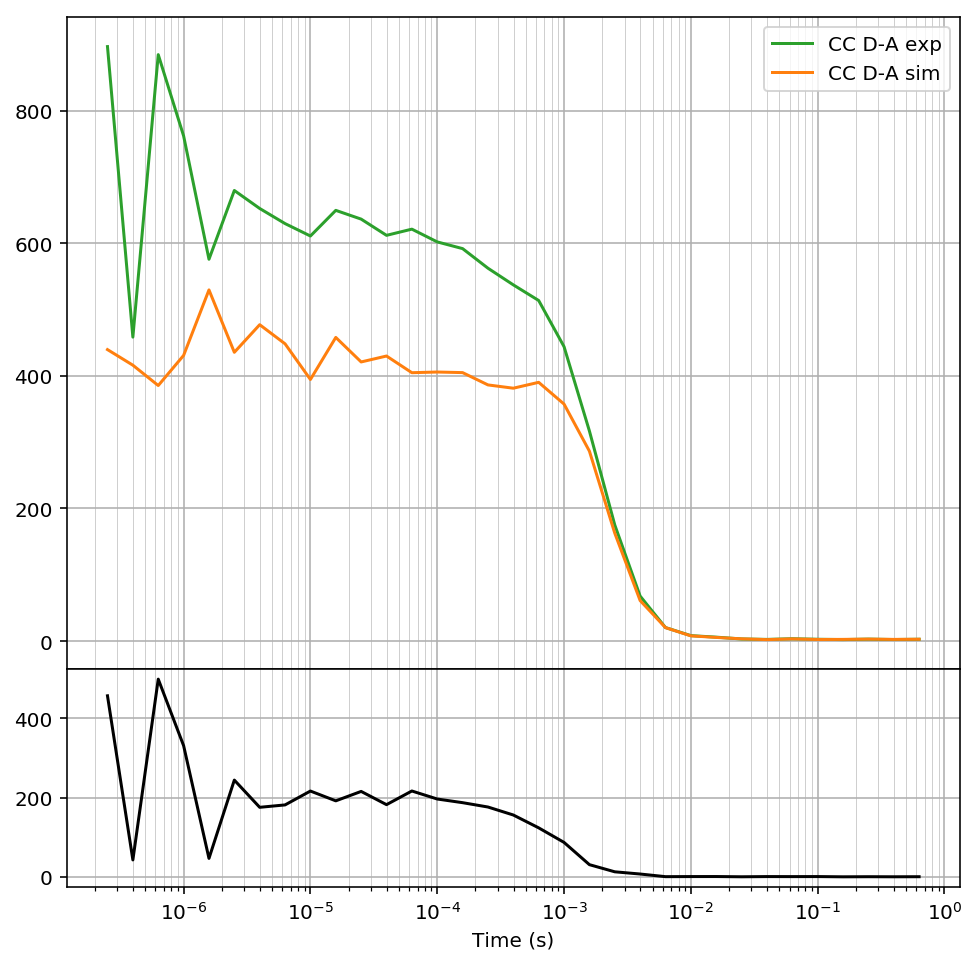

In [214]:
timelags = fcs_bins[:-1] * 1e-9
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(timelags, CC_DA_exp, color='C2', label='CC D-A exp')
ax[0].semilogx(timelags, CC_DA_sim, color='C1', label='CC D-A sim')
ax[1].plot(timelags, CC_DA_exp - CC_DA_sim, color='k')
ax[1].set_xlabel('Time (s)')
ax[0].legend()
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3);

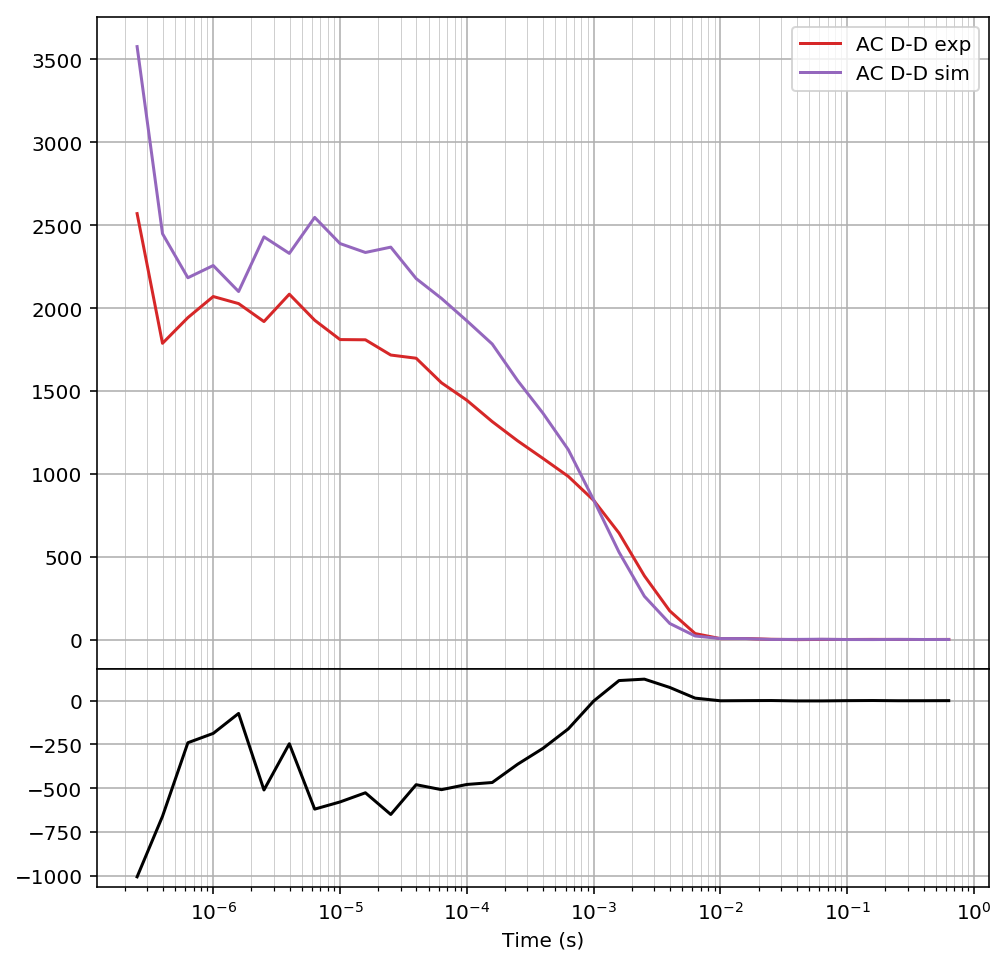

In [215]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(timelags, AC_DD_exp,  color='C3', label='AC D-D exp')
ax[0].semilogx(timelags, AC_DD_sim, color='C4', label='AC D-D sim')
ax[1].plot(timelags, AC_DD_exp - AC_DD_sim, color='k')
ax[1].set_xlabel('Time (s)')
ax[0].legend()
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3);

# Fitting

## Fit setup

In [50]:
def fitres_to_df(res, params_names):
    df = pd.DataFrame(res.x_iters, columns=params_names)
    df['loss'] = res.func_vals
    df.index.name = 'iteration'
    return df

def df_to_xy(df):
    df = df.copy()
    y = df['loss'].values
    x = df.drop(columns='loss').values
    x = [list(p) for p in x]
    return x, y

Fit setup (input data, separate varying and constant params):

In [92]:
fit_name = f'E_nanotime_dyn'
fname_fitres = f'results/checkpoint_{fit_name}'
ts = burstsph_sel.loc[Dex, 'timestamp']
recolor_func = loss.recolor_burstsph_gauss

bounds = {
    'R_mean': (3.0, 4.2), 
    'R_sigma': (0.5, 1.9),
    'τ_relax': (0.2, 2.),
    'prob_A_dark': (0., 0.04),
    'τ_A_dark': (0.5, 4.),    # [ms]
}
bounds_list = list(bounds.values())
params_vary_names = list(bounds.keys())

params_vary = [params[n]*1e-6 if n == 'τ_A_dark' else params[n]
               for n in params_vary_names]
params_const = {k: v for k, v in params.items() 
                if k not in params_vary_names}

We minimize the function `loss.loss_E_nanot()`. 

All the required fixed input arguments are computed below:

In [52]:
# E loss 
E_bins = np.arange(0, 1.1, 0.03)
E_exp = bursts_sel.E
E_loss_std = 16.957

# Nanotimes loss
loglike_d_std = 50.16
loglike_a_std = 47.64
nanot_loss_std = 1.24
offset_Dex = tcspc.decay_hist_offset(burstsph_sel.loc[Dex, 'nanotime'], 
                                     tcspc_unit, 4095, rebin=4) * 1e9
u = 1 / (tcspc_unit * 1e9)
nt_bins = np.arange(-2*u, 22*u, 2)
nanot_hist_d_exp, nanot_hist_a_exp = loss.nanot_hist_from_burstph(
    burstsph_sel, nt_bins, offset=offset_Dex / (1e9*tcspc_unit))

loss_tot = loss.loss_E_nanot(
    params_vary, params_const, ts, recolor_func=recolor_func,
    # E loss arguments
    E_exp=E_exp, E_bins=E_bins,
    # Nanotime loss arguments
    irf=irf, nt_bins=nt_bins, tcspc_unit=tcspc_unit, 
    nanot_hist_d_exp=nanot_hist_d_exp, nanot_hist_a_exp=nanot_hist_a_exp,
    loglike_d_std=loglike_d_std, loglike_a_std=loglike_a_std, irf_seed=1,
    # Indiviadual losses standard deviations
    E_loss_std=E_loss_std, nanot_loss_std=nanot_loss_std, 
    cache=False)
loss_tot

36.7601922588358

The function passed to the optimizer must take only the varying parameters.
Here we create `loss_func_partial`, which
is obtained by preassigning all the fixed arguments (see docs for python function  [`partial`](https://docs.python.org/3.6/library/functools.html#functools.partial)).
`loss_func_partial` takes only the varying parameters as arguments:

In [53]:
loss_func_partial = partial(
    loss.loss_E_nanot, params_const=params_const, ts=ts, 
    recolor_func=recolor_func,
    # E loss arguments
    E_exp=E_exp, E_bins=E_bins,
    # Nanotime loss arguments
    irf=irf, nt_bins=nt_bins, tcspc_unit=tcspc_unit, 
    nanot_hist_d_exp=nanot_hist_d_exp, nanot_hist_a_exp=nanot_hist_a_exp,
    loglike_d_std=loglike_d_std, loglike_a_std=loglike_a_std, irf_seed=1,
    # Indiviadual losses standard deviations
    E_loss_std=E_loss_std, nanot_loss_std=nanot_loss_std, 
    cache=False)

In [54]:
loss_func_partial(params_vary)

36.7601922588358

## Bootstrap the fit 

Run only the first time to get the first few fit iterations:

In [55]:
fname_fitres

'results/checkpoint_E_nanotime_dyn'

In [96]:
def _print_status(res):
    print(res.func_vals.size, end=' ', flush=True)

print(f'Checkpoint file name: {fname_fitres}.pkl')
checkpoint_saver = CheckpointSaver(f"{fname_fitres}.pkl", compress=9) 

Checkpoint file name: results/checkpoint_E_nanotime_dyn.pkl


In [58]:
start = tic()
x0 = params_vary
res = gp_minimize(loss_func_partial,                 
                  bounds_list,          # the bounds on each dimension of x
                  x0=x0, 
                  #acq_func="EI",       # the acquisition function
                  n_calls=20,           # the number of evaluations of f 
                  n_random_starts=10,   # the number of random initialization points
                  noise=(1.)**2,        # variance of the loss function
                  callback=[checkpoint_saver, _print_status],
                  random_state=1)       # the random seed
duration = tic() - start
print(f'[{fname_fitres}] Initial fit duration: {duration:.1f} s')

fit_status = fitres_to_df(res, params_vary_names)
fit_status.to_csv(fname_fitres + '.csv')
print(f'Iterations: {fit_status.shape[0]}')
fit_status.head()

## Continue the fit

Run this to add more fitting iteration after the first time:

In [105]:
fname_fitres

'results/checkpoint_E_nanotime_dyn'

In [106]:
fit_status = pd.read_csv(fname_fitres + '.csv', index_col=0)
print(f'Iterations: {fit_status.shape[0]}')
fit_status.head()

Iterations: 620


,R_mean,R_sigma,τ_relax,prob_A_dark,τ_A_dark,loss
iteration,,,,,,
0,3.438305,1.769286,0.818881,0.022884,2.663055,36.760192
1,4.197185,1.805580,0.430624,0.039962,1.326311,43.763998
2,3.596581,1.043075,1.405543,0.037422,3.462088,44.580202
3,3.513274,1.234367,0.998215,0.009183,2.370449,64.823293
4,4.113962,1.140087,0.975257,0.037565,3.224362,54.078688


In [97]:
start = tic()
x0, y0 = df_to_xy(fit_status)
res4 = gp_minimize(loss_func_partial,                 
                   bounds_list,          # the bounds on each dimension of x
                   x0=x0,                # already examined values for x
                   y0=y0,                # observed values for x0
                   #acq_func="EI",       # the acquisition function
                   n_calls=400,          # the number of evaluations of f 
                   n_random_starts=10,   # the number of random initialization points
                   noise=(1.)**2,        # variance of the loss function
                   callback=[checkpoint_saver, _print_status],
                   random_state=1)       # the random seed
duration = tic() - start
duration

420 421 422 423 424 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 

OSError: [Errno 5] Input/output error

In [56]:
fname_fitres + '.csv'

'results/checkpoint_E_nanotime_dyn.csv'

In [68]:
# fit_status = pd.read_csv(fname_fitres + '.csv', index_col=0)
# fit_status

,R_mean,R_sigma,τ_relax,prob_A_dark,τ_A_dark,loss
iteration,,,,,,
0,3.438305,1.769286,0.818881,0.022884,2.663055,36.760192
1,4.197185,1.805580,0.430624,0.039962,1.326311,43.763998
...,...,...,...,...,...,...
418,3.200000,1.008343,2.000000,0.024387,3.429080,37.237118
419,3.200000,1.419422,1.156025,0.030069,3.390688,36.097036


In [82]:
fit_status = fitres_to_df(res4, params_vary_names)
fit_status.to_csv(fname_fitres + '.csv')
print(f'Iterations: {fit_status.shape[0]}')
fit_status.head()

Iterations: 420


,R_mean,R_sigma,τ_relax,prob_A_dark,τ_A_dark,loss
iteration,,,,,,
0,3.438305,1.769286,0.818881,0.022884,2.663055,36.760192
1,4.197185,1.805580,0.430624,0.039962,1.326311,43.763998
2,3.596581,1.043075,1.405543,0.037422,3.462088,44.580202
3,3.513274,1.234367,0.998215,0.009183,2.370449,64.823293
4,4.113962,1.140087,0.975257,0.037565,3.224362,54.078688


In [108]:
res4.func_vals.shape

(620,)

In [99]:
res3 = skopt.load(fname_fitres + '.pkl')

KeyError: 63

In [60]:
ll = loss_func_partial(res3.x)
assert ll == res3.fun

Previous fit duration: 1 s


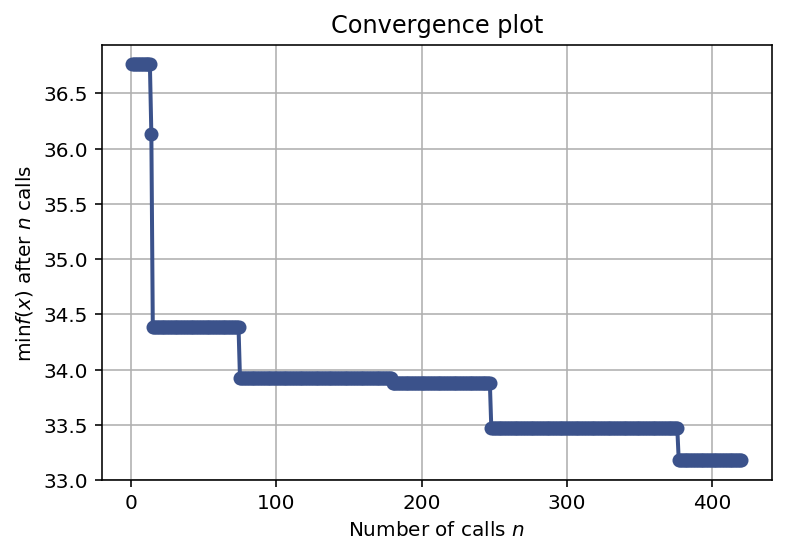

In [63]:
plot_convergence(res3);
print(f'Previous fit duration: {duration} s')

In [64]:
res3.fun

33.183066514551385

In [65]:
idx_min = np.where(res3.func_vals == res3.func_vals.min())[0][0]
assert res3.x == res3.x_iters[idx_min]

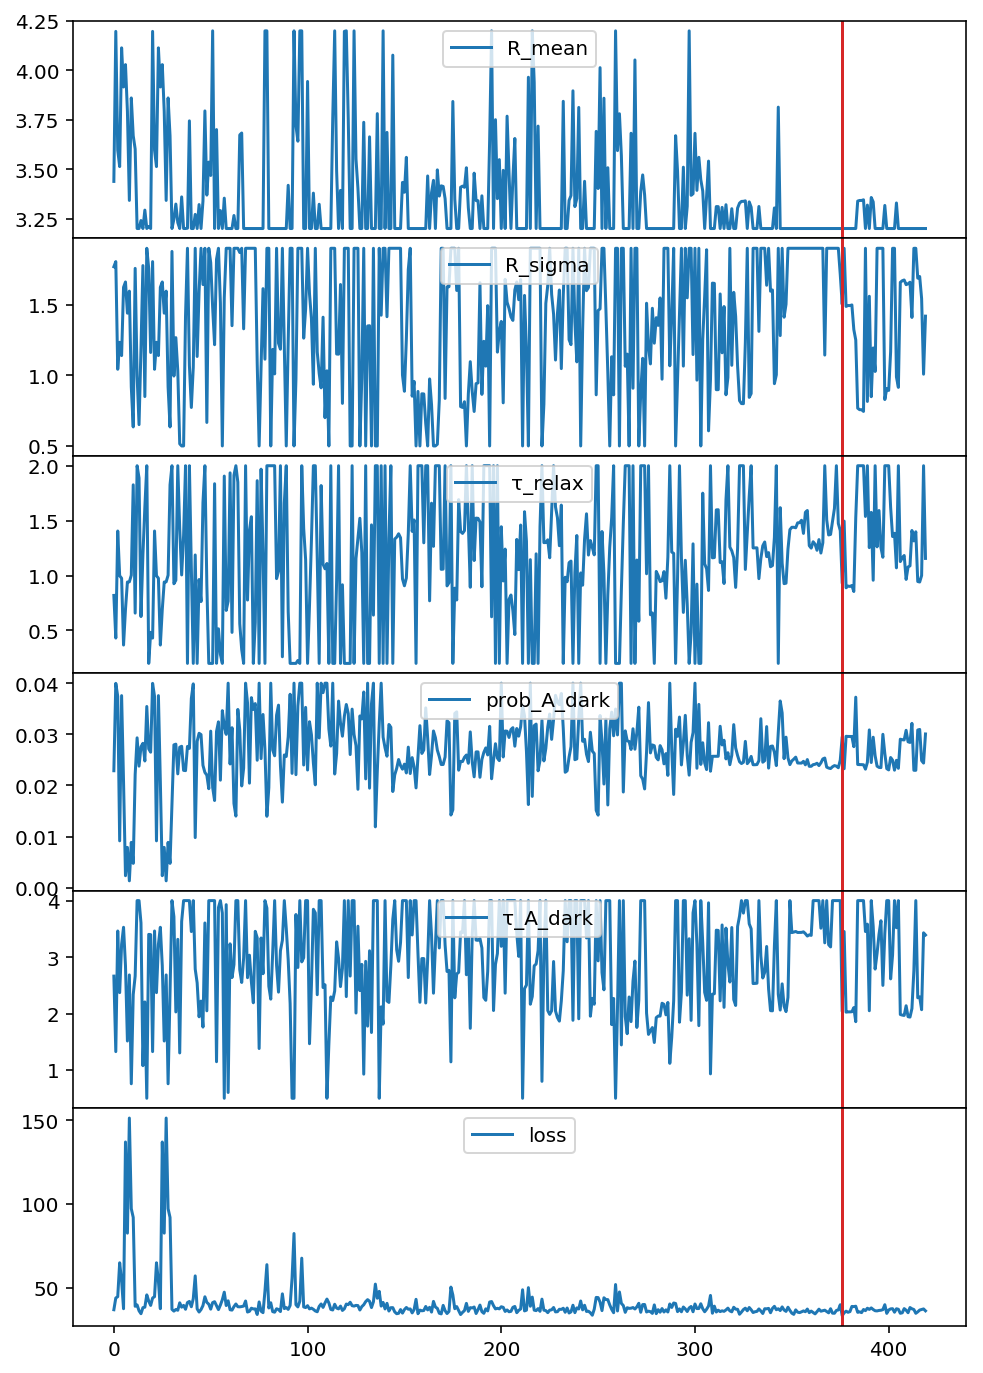

In [69]:
fig, Ax = plt.subplots(fit_status.shape[1], 1, sharex=True,
                       figsize=(8, fit_status.shape[1]*2))
plt.subplots_adjust(hspace=0)
for col, ax in zip(fit_status, Ax):
    ax.plot(fit_status[col], label=col)
    ax.legend(loc='upper center')
    ax.axvline(idx_min, color='C3')

(0, 60)

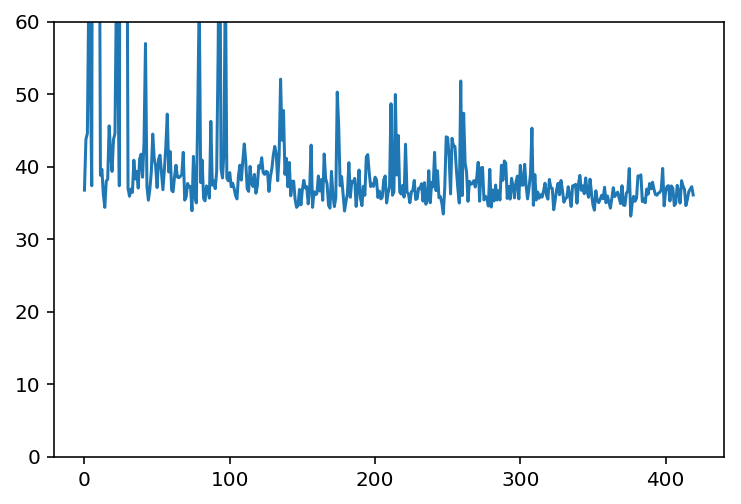

In [70]:
col='loss'
plt.plot(fit_status[col], label=col)
plt.ylim(0, 60)

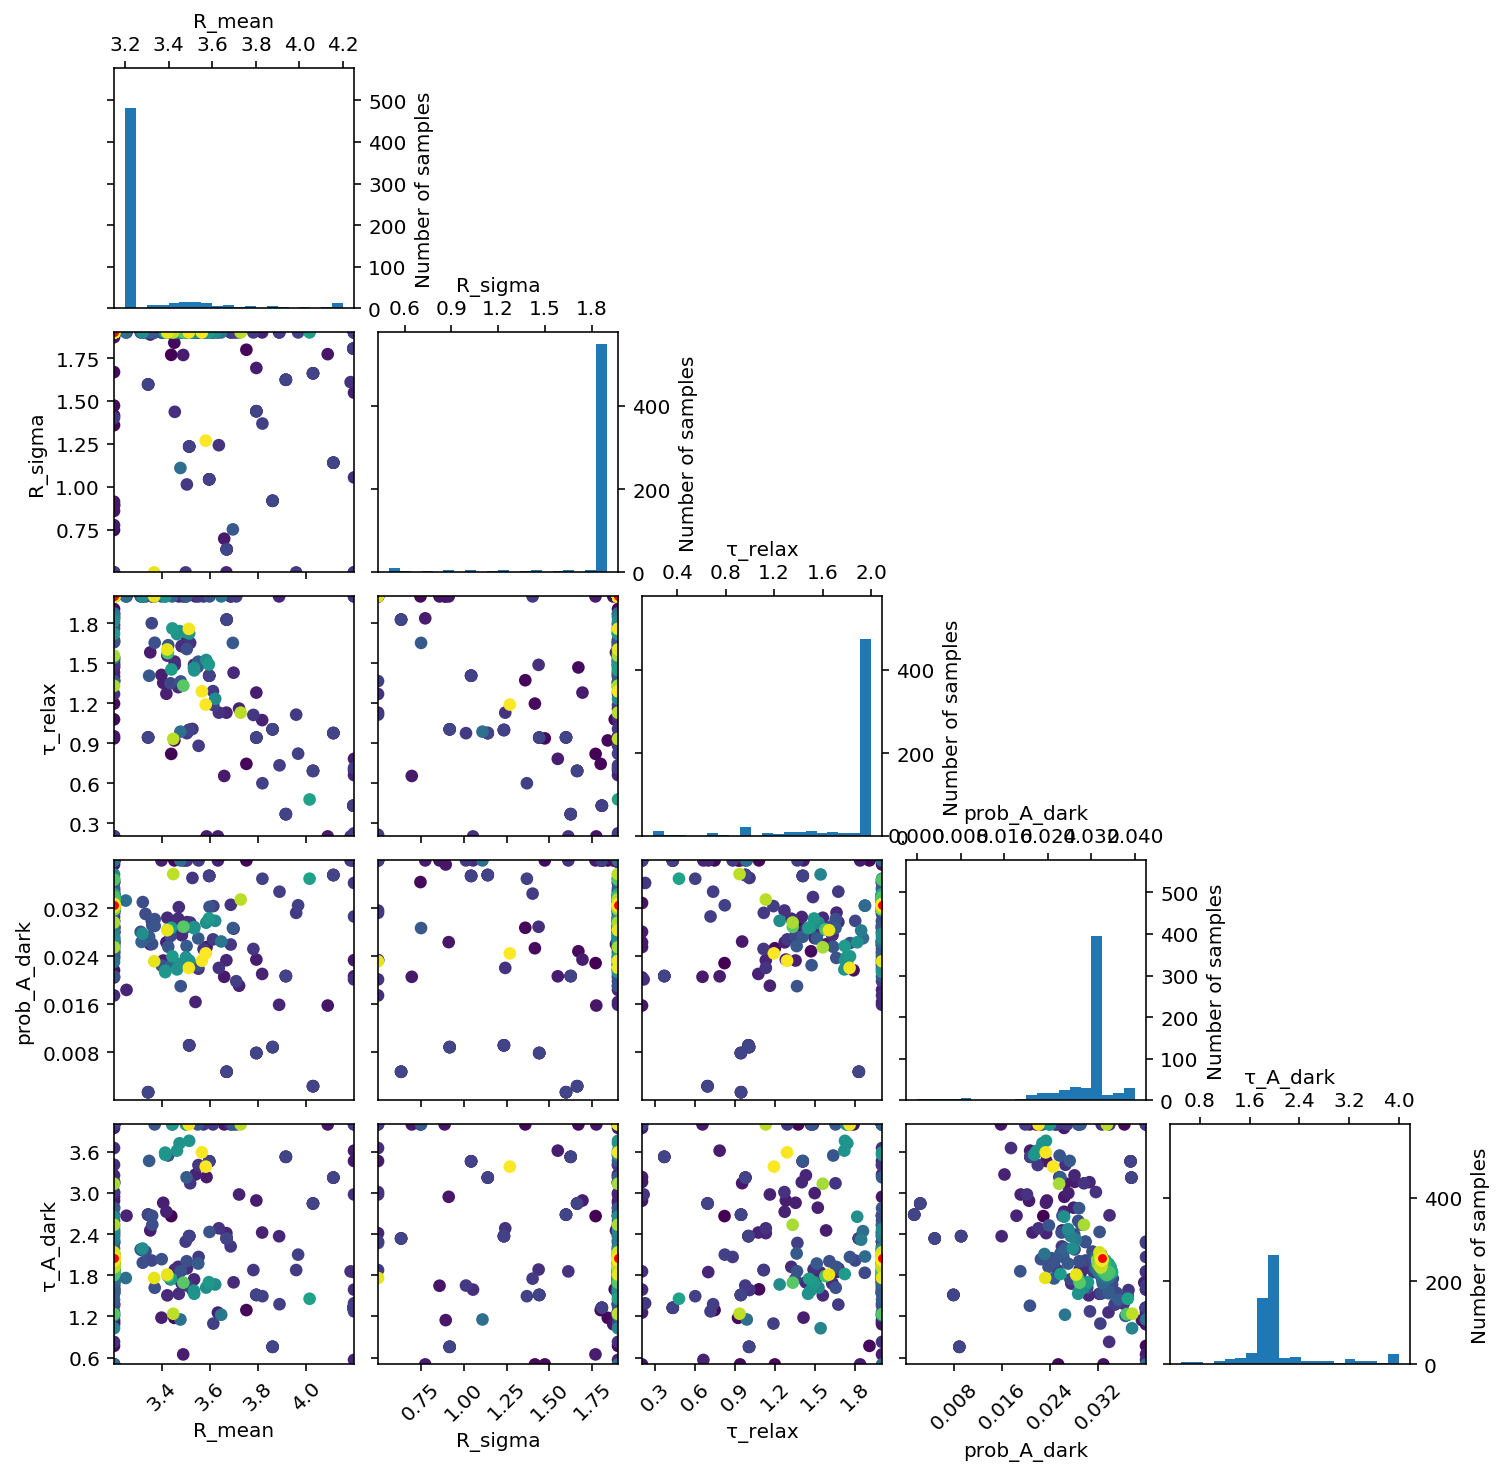

In [92]:
plot_evaluations(res3, dimensions=params_vary_names);

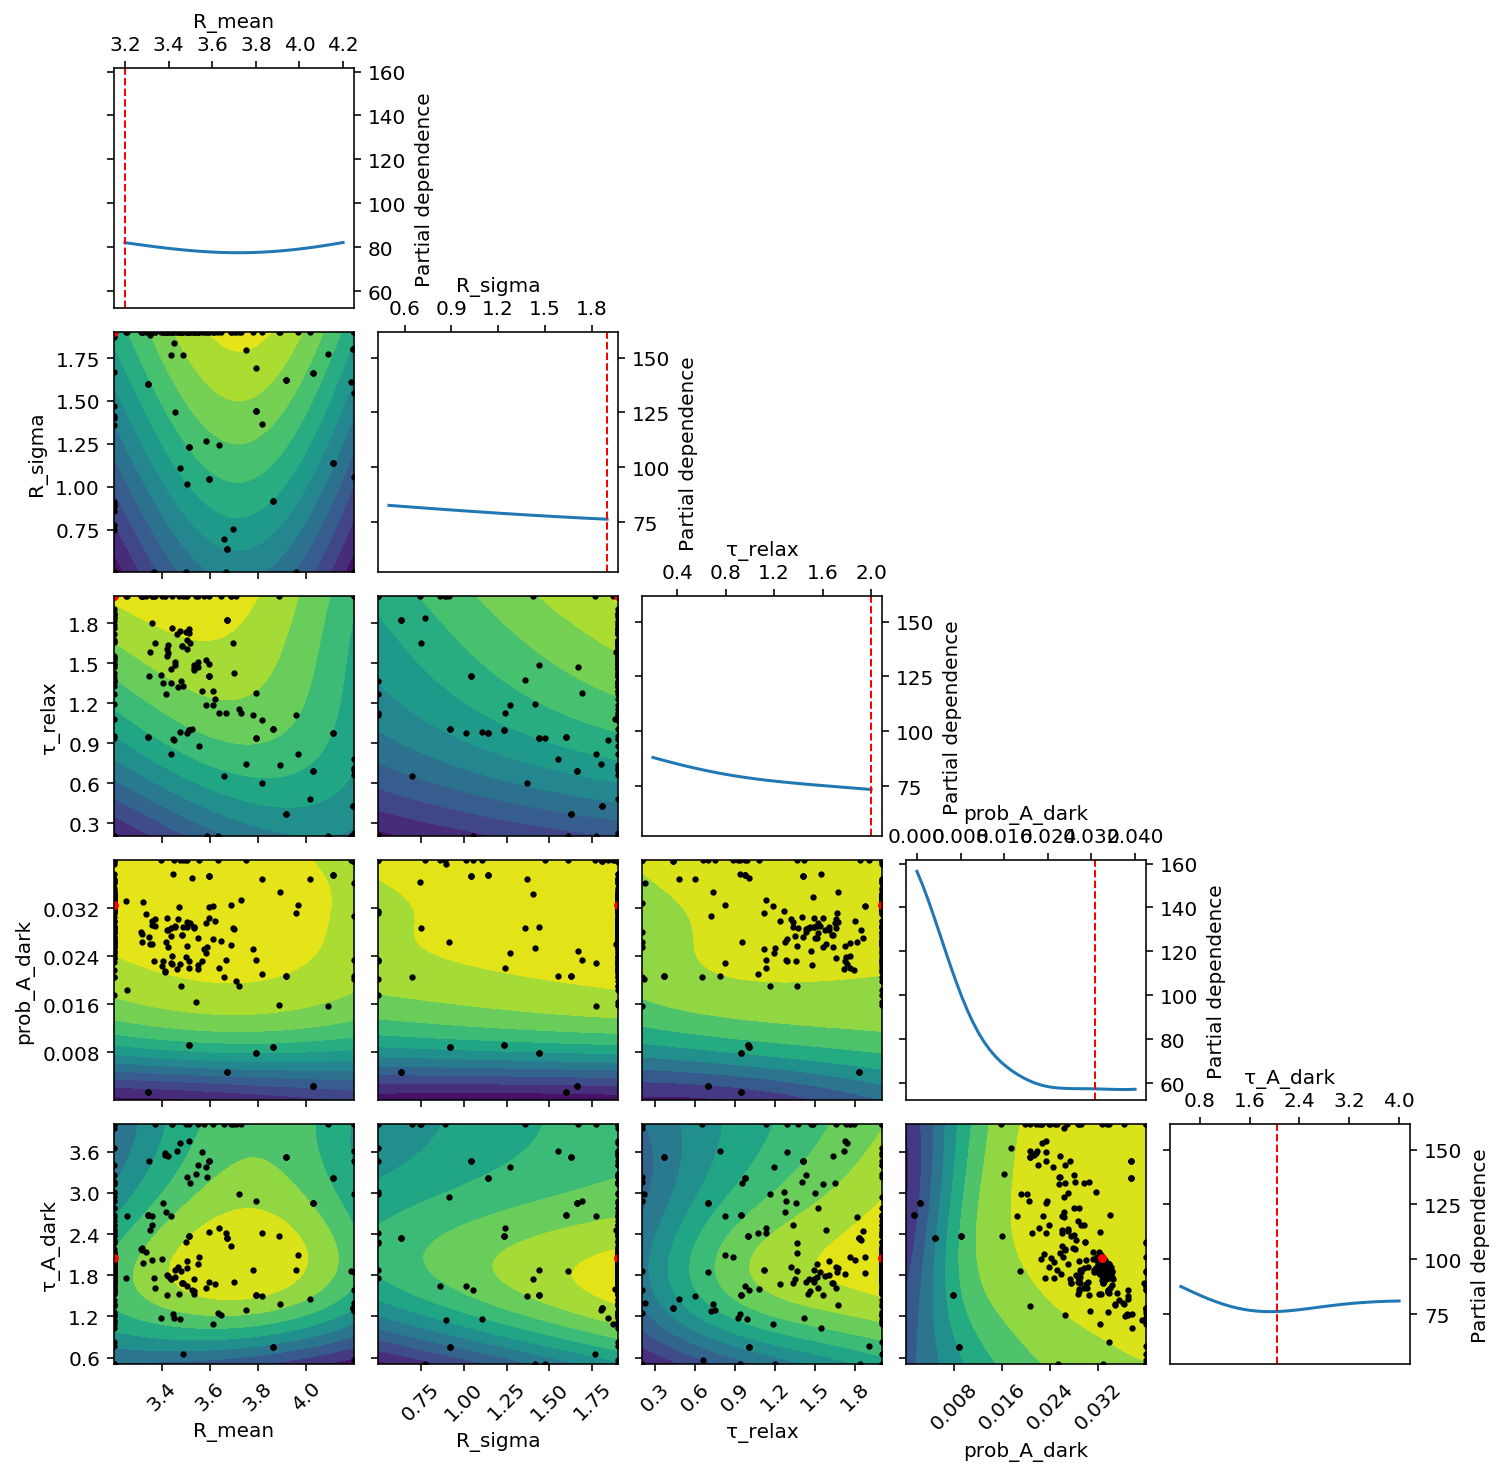

In [93]:
plot_objective(res3, dimensions=params_vary_names);

## Best-fit simulation

In [71]:
params_vary_o = {n: v if n != 'τ_A_dark' else v*1e6 
                 for n, v in zip(params_vary_names,
                                 res3.x_iters[idx_min])}
params_opt = {**params_vary_o, **params_const}
params_opt

{'D_fract': [0.9381886541859179, 0.06181134581408213],
 'R0': 5.54919485935689,
 'R_mean': 3.2,
 'R_sigma': 1.5028747623323504,
 'bg_rate_a': 608.8373653645194,
 'bg_rate_d': 317.47525154002346,
 'dir_ex_t': 0.06,
 'dr': 0.0001,
 'du': 0.001,
 'gamma': 0.78,
 'lk': 0.055,
 'name': 'gaussian',
 'ndt': 10,
 'prob_A_dark': 0.029503097545782786,
 'tcspc_range': 22.765939383,
 'ts_unit': 1e-09,
 'u_max': 6,
 'α': 0.1,
 'δt': 0.014678232999999999,
 'τ_A': 4.050585,
 'τ_A_dark': 2039160.41518693,
 'τ_D': [4.0159, 0.374247],
 'τ_relax': 0.9294848515018406}

In [74]:
import importlib
importlib.reload(depi.depi)
importlib.reload(depi)

<module 'depi' from '/opt/src/depi/depi/__init__.py'>

In [75]:
# params_opt, _, _ = depi.load_params('results/G_1s_D_B_opt_E_fcs_nanot_617.json')

In [76]:
burstsph_sim = depi.recolor_burstsph_cache(ts, **params_opt)

________________________________________________________________________________
[Memory] Calling depi.depi.recolor_burstsph_cache...
recolor_burstsph_cache(burst  ph
0      0         102993700
       1         103160300
                 ...      
1480   90    2967025133000
       91    2967025137400
Name: timestamp, Length: 44540, dtype: int64, R_mean=3.2, R_sigma=1.5028747623323504, τ_relax=0.9294848515018406, prob_A_dark=0.029503097545782786, τ_A_dark=2039160.41518693, D_fract=[0.9381886541859179, 0.06181134581408213], R0=5.54919485935689, bg_rate_a=608.8373653645194, bg_rate_d=317.47525154002346, dir_ex_t=0.06, dr=0.0001, du=0.001, gamma=0.78, lk=0.055, name='gaussian', ndt=10, tcspc_range=22.765939383, ts_unit=1e-09, u_max=6, α=0.1, δt=0.014678232999999999, τ_A=4.050585, τ_D=[4.0159, 0.374247])
___________________________________________recolor_burstsph_cache - 8.4s, 0.1min


In [77]:
bounds

{'R_mean': (3.2, 4.2),
 'R_sigma': (0.5, 1.9),
 'prob_A_dark': (0.0, 0.04),
 'τ_A_dark': (0.5, 4.0),
 'τ_relax': (0.2, 2.0)}

In [78]:
fit_name

'E_nanotime_dyn'

In [79]:
f'results/G_1s_D_B_opt_E_nanot_{fit_status.shape[0]}.json'

'results/G_1s_D_B_opt_E_nanot_420.json'

In [80]:
depi.save_params(f'results/G_1s_D_B_opt_E_nanot_{fit_status.shape[0]}.json', 
                 params_opt, bounds, fit_name)

In [118]:
# params2, bounds2, fit_name2 = depi.load_params('results/G_1s_D_B_opt_E_fcs_nanot_617.json')

# assert params2 == params_opt
# assert fit_name2 == fit_name
# assert {k: tuple(v) for k, v in bounds2.items()} == bounds
# fit_name2

'E_fcs_nanotime_dyn'

In [81]:
E = fret.calc_E_burst(burstsph_sim)

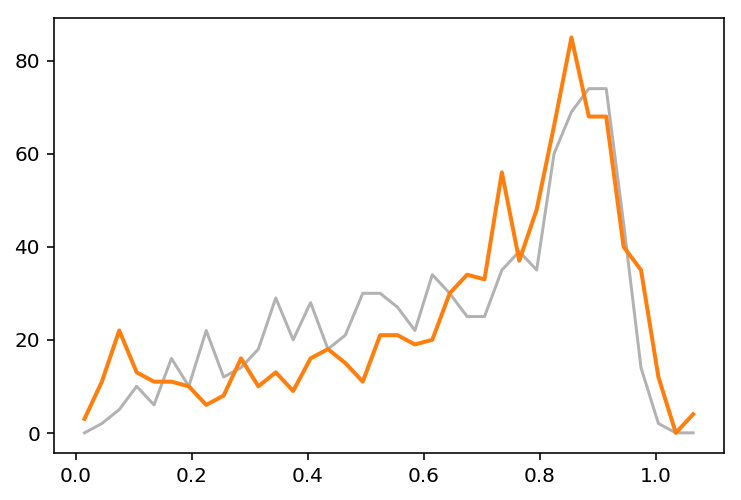

In [82]:
bins = np.arange(0, 1.1, 0.03)
E_hist, _ = np.histogram(E, bins=bins)
x = bins[0:-1] + 0.5 * (bins[1] - bins[0])
E_hist_exp, _ = np.histogram(bursts_sel.E, bins=bins)
plt.plot(x, E_hist, color='k', alpha=0.3)
plt.plot(x, E_hist_exp, color='C1', lw=2);

<IPython.core.display.Math object>

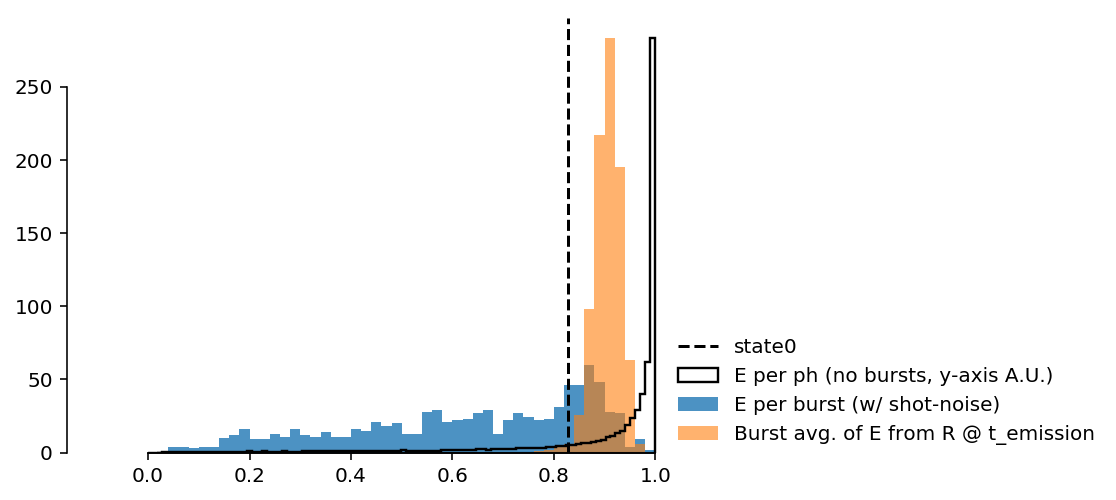

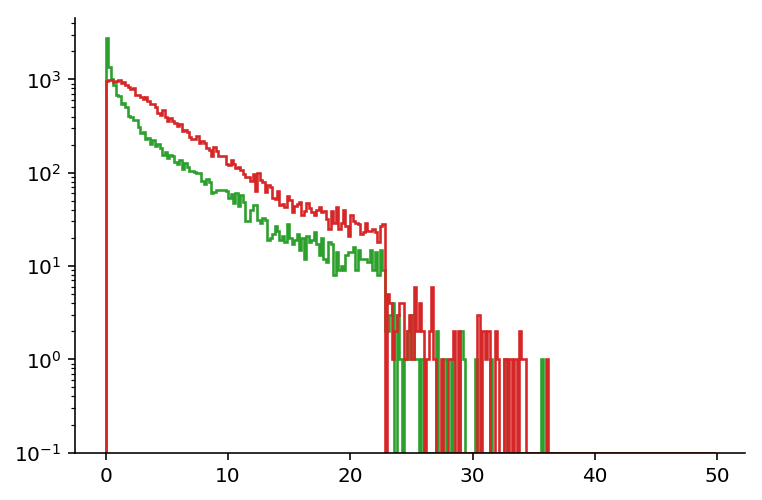

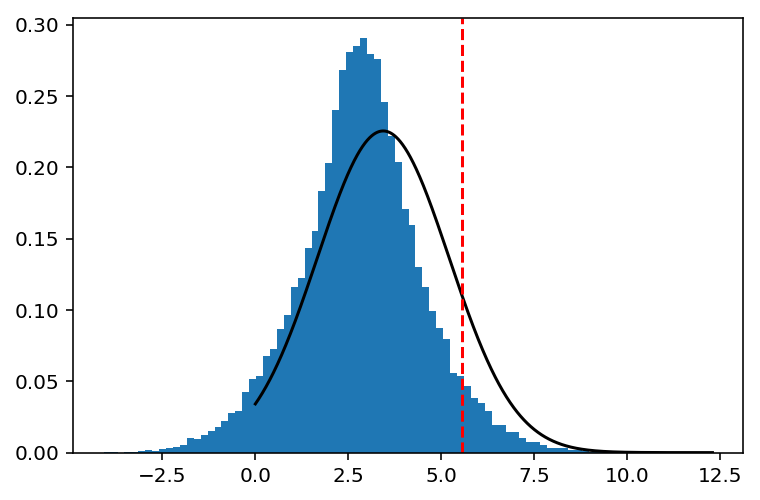

In [99]:
pl.plot_E_sim(burstsph_sim, params, E=E);
pl.plot_nanotimes(burstsph_sim);
plt.figure()
plt.hist(burstsph_sim.R_ph, bins=80, density=True)
pl.plot_R_distrib(params, ax=plt.gca());

# Nanotimes analysis

In [302]:
nanot_hist_d_sim, nanot_hist_a_sim = loss.calc_nanot_hist_irf_da(
        burstsph_sim, irf, nt_bins, tcspc_unit, nanot_hist_d_exp, nanot_hist_a_exp)
residuals_d = nanot_hist_d_exp - nanot_hist_d_sim
residuals_a = nanot_hist_a_exp - nanot_hist_a_sim

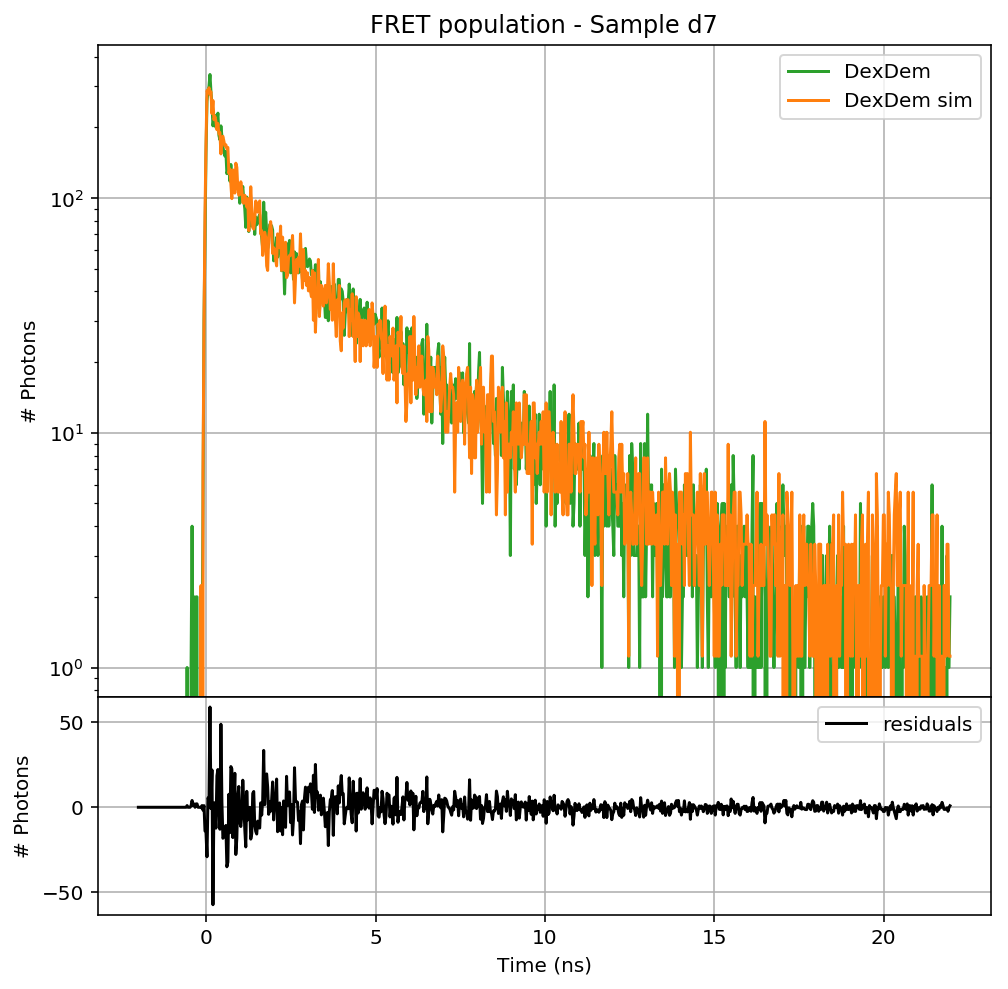

In [303]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3,1]})
plt.subplots_adjust(hspace=0)
time_axis = nt_bins[:-1] * meta['nanotime_unit'] * 1e9
ax[0].plot(time_axis, nanot_hist_d_exp, color='C2', label='DexDem')
ax[0].plot(time_axis, nanot_hist_d_sim, color='C1', label='DexDem sim')
ax[1].plot(time_axis, residuals_d, color='k', label='residuals')
ax[0].set_yscale('log')
for a in ax:
    a.grid(True)
    a.legend();
    a.set_ylabel('# Photons');
ax[1].set_xlabel('Time (ns)');
ax[0].set_title(f'FRET population - {label}');

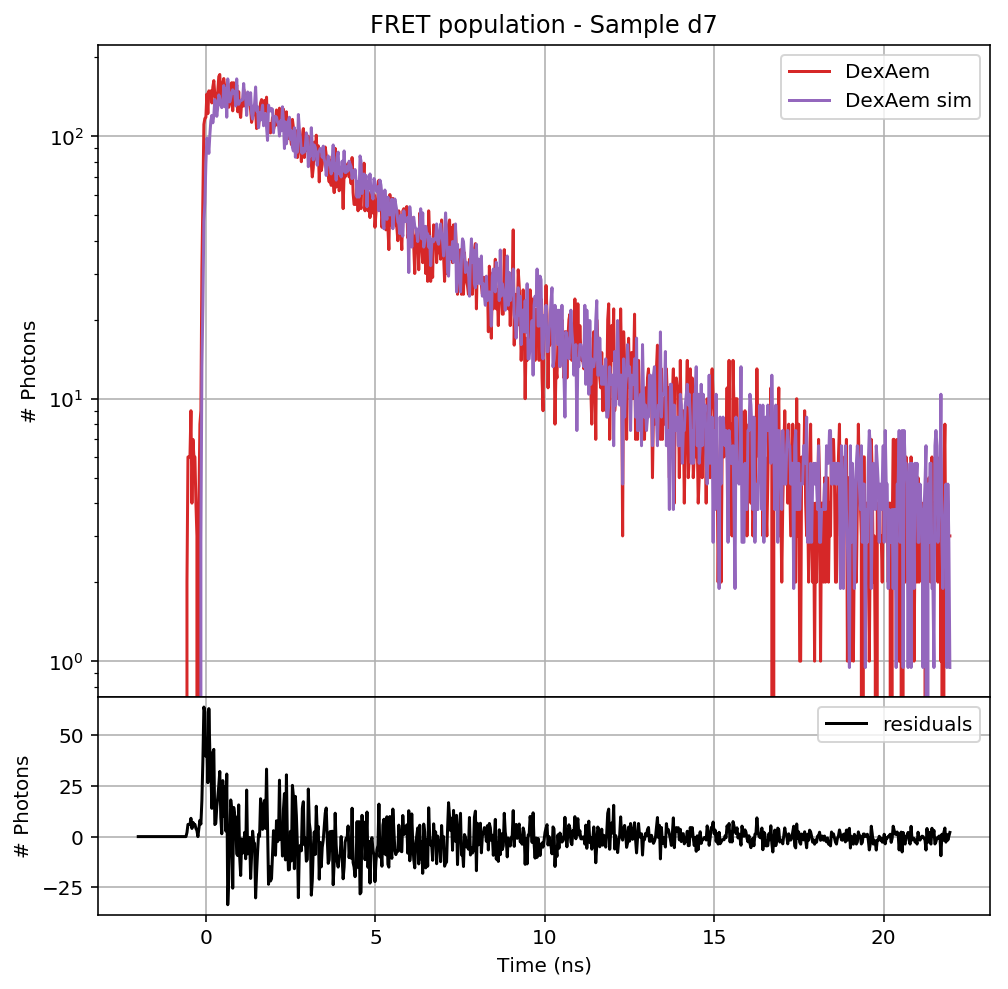

In [304]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
time_axis = nt_bins[:-1] * meta['nanotime_unit'] * 1e9
ax[0].plot(time_axis, nanot_hist_a_exp, color='C3', label='DexAem')
ax[0].plot(time_axis, nanot_hist_a_sim, color='C4', label='DexAem sim')
ax[1].plot(time_axis, residuals_a, color='k', label='residuals')
ax[0].set_yscale('log')
for a in ax:
    a.grid(True)
    a.legend();
    a.set_ylabel('# Photons');
ax[1].set_xlabel('Time (ns)');
ax[0].set_title(f'FRET population - {label}');

## Add IRF to nanotimes

In [305]:
nt_d = burstsph_sim.loc[burstsph_sim.stream == 'DexDem', 'nanotime']
nt_a = burstsph_sim.loc[burstsph_sim.stream == 'DexAem', 'nanotime']

IRF_t_sim = irf.index - irf.index[0]
_DD_valid = ~irf.DD_smooth1.isnull()
_DA_valid = ~irf.DA_smooth1.isnull()
IRF_DD_rnd = np.random.choice(IRF_t_sim[_DD_valid], p=irf.DD_smooth1.loc[_DD_valid], size=len(nt_d))
IRF_DA_rnd = np.random.choice(IRF_t_sim[_DA_valid], p=irf.DA_smooth1.loc[_DA_valid], size=len(nt_a))

In [306]:
nt_th = 26.1
DD = burstsph_sel.stream == 'DexDem'
DA = burstsph_sel.stream == 'DexAem'
AA = burstsph_sel.stream == 'AexAem'

nanotimes_d = burstsph_sel.nanotime.loc[DD]
nanotimes_a = burstsph_sel.nanotime.loc[DA]

nanotimes_d_offset = nanotimes_d * tcspc_unit * 1e9 - nt_th
nanotimes_a_offset = nanotimes_a * tcspc_unit * 1e9 - nt_th

Decay_bins = np.arange(0, 50, tcspc_unit * 1e9 * 5)

hist_params = dict(bins=Decay_bins, density=False)
nanot_hist_d_offset, _ = np.histogram(nanotimes_d_offset, **hist_params)
nanot_hist_a_offset, _ = np.histogram(nanotimes_a_offset, **hist_params)

In [307]:
nt_d_conv = nt_d + IRF_DD_rnd - IRF_DD_rnd.mean()
nt_a_conv = nt_a + IRF_DA_rnd - IRF_DA_rnd.mean()

In [308]:
assert nt_d_conv.shape[0] + nt_a_conv.shape[0] == burstsph_sim.shape[0]

In [309]:
burstsph_sim['nanotime_conv'] = pd.concat([nt_d_conv, nt_a_conv]).sort_index()

assert (burstsph_sim.loc[burstsph_sim.stream == 'DexDem', 'nanotime_conv'] == nt_d_conv).all()
assert (burstsph_sim.loc[burstsph_sim.stream == 'DexAem', 'nanotime_conv'] == nt_a_conv).all()
burstsph_sim.head(5)

timestamp  nanotime      R_ph   A_ch  leak_ph  dir_ex_ph  A_dark_ph  \
burst ph                                                                        
0     0   102993700  1.278266  4.520295  False    False      False      False   
      1   103160300  1.680683 -0.134371   True    False      False      False   
      4   103753500  4.631406  2.266283   True    False      False      False   
      6   103802600  0.000000  1.444093  False    False       True       True   
      7   103848400  0.000000  1.321836  False    False       True       True   

          bg_ph  stream  nanotime_conv  nanotime_conv_unit  
burst ph                                                    
0     0    True  DexDem       1.509059                 103  
      1   False  DexAem       1.591002                 126  
      4   False  DexAem       4.644473                 325  
      6   False  DexDem      -0.048093                  21  
      7   False  DexDem       0.553715                   3

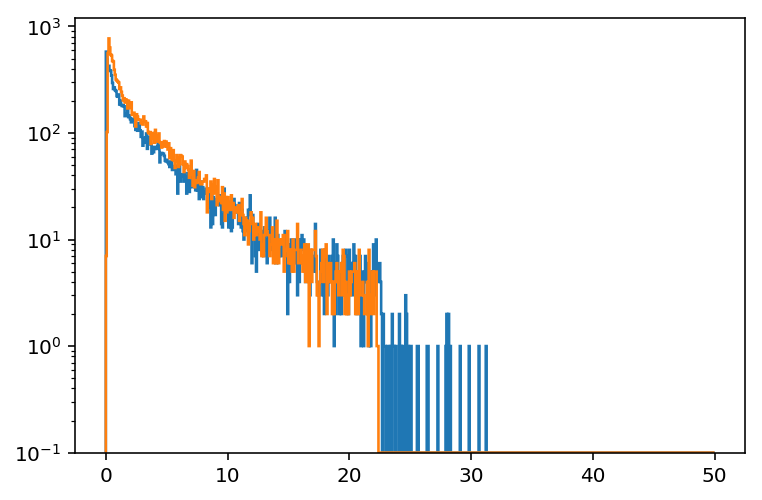

In [310]:
kws = dict(bins = np.arange(0, 50, tcspc_unit * 1e9 * 5), 
           log=True, histtype='step', lw=1.3);

cnt_d_sim, bins, _ = plt.hist(nt_d_conv, **kws);
cnt_d_exp, bins, _ = plt.hist(nanotimes_d_offset, **kws);

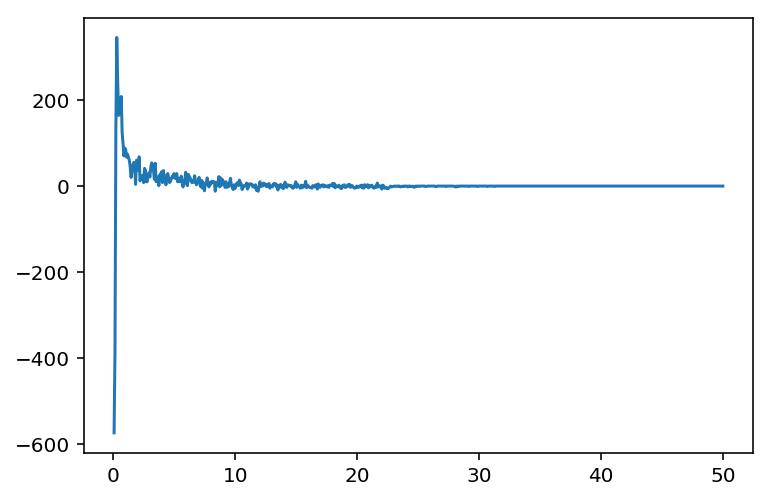

In [311]:
plt.plot(bins[1:], cnt_d_exp - cnt_d_sim)

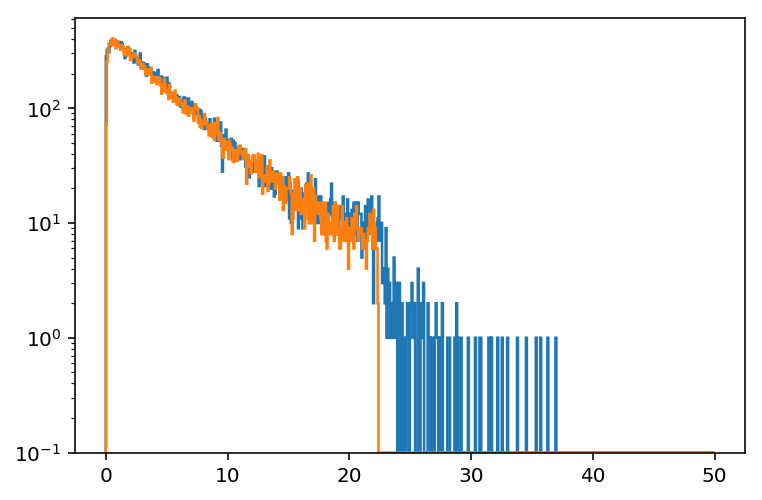

In [312]:
kws = dict(bins = np.arange(0, 50, tcspc_unit * 1e9 * 5), 
           log=True, histtype='step', lw=1.3);

cnt_a_sim, bins, _ = plt.hist(nt_a_conv, **kws);
cnt_a_exp, bins, _ = plt.hist(nanotimes_a_offset, **kws);

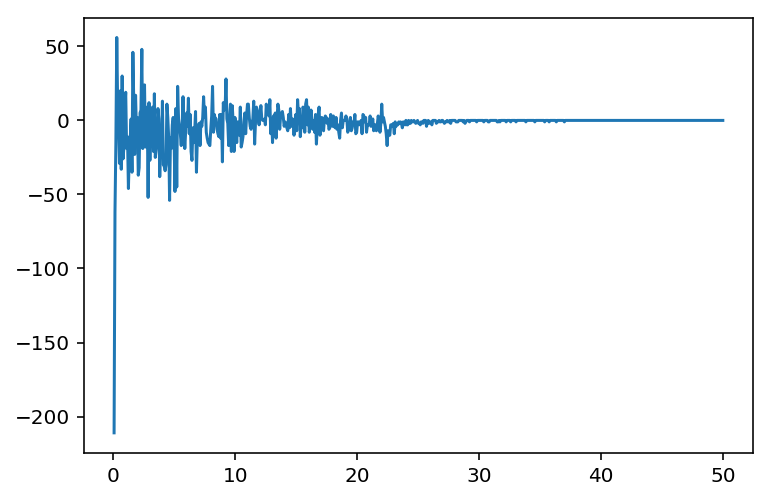

In [313]:
plt.plot(bins[1:], cnt_a_exp - cnt_a_sim)

## Mean nanotimes

In [ ]:
mean_nanot_sim = (burstsph_sim.groupby(['burst', 'stream'])['nanotime_conv','nanotime']
                  .mean()
                  .reset_index('stream'))
DD = mean_nanot_sim.stream == 'DexDem'
DA = mean_nanot_sim.stream == 'DexAem'

mean_nanot_sim_DD_conv = mean_nanot_sim.loc[DD, 'nanotime_conv']
mean_nanot_sim_DD = mean_nanot_sim.loc[DD, 'nanotime']
mean_nanot_sim_DA_conv = mean_nanot_sim.loc[DA, 'nanotime_conv']
mean_nanot_sim_DA = mean_nanot_sim.loc[DA, 'nanotime']

In [ ]:
# Comparison of mean nanotime histograms for Donor
bins = np.arange(0, 10, 0.1)

plt.hist(mean_nanot_sim_DD, bins=bins, range=(0, 10));
plt.hist(mean_nanot_sim_DD_conv, bins=bins, range=(0, 10), alpha=0.5);

In [ ]:
# Comparison of mean nanotime histograms for Acceptor
bins = np.arange(0, 10, 0.1)

plt.hist(mean_nanot_sim_DA, bins=bins, range=(0, 10));
plt.hist(mean_nanot_sim_DA_conv, bins=bins, range=(0, 10), alpha=0.5);

In [ ]:
E = fret.calc_E_burst(burstsph_sim)
burst_sim = pd.DataFrame(dict(E=E, 
                              mean_nt_dd=mean_nanot_sim_DD, 
                              mean_nt_da=mean_nanot_sim_DA, 
                              mean_nt_E=1 - mean_nanot_sim_DD / τ_D_mean,
                              mean_nt_dd_conv=mean_nanot_sim_DD_conv,
                              mean_nt_da_conv=mean_nanot_sim_DA_conv,
                              mean_nt_E_conv=1 - mean_nanot_sim_DD_conv / τ_D_mean))
DDv = ~burst_sim.mean_nt_dd.isnull()
DAv = ~burst_sim.mean_nt_da.isnull()

In [ ]:
# Mean donor nanotime vs. FRET - not IRF convoluted
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1,0.01)
y = τ_D_mean * (1 - x)
plt.plot(x, y, lw=2, color='k', ls='--')

im = sns.kdeplot(burst_sim.loc[DDv, 'E'], burst_sim.loc[DDv, 'mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.xlim(-0.05,1.05, 0.2)
plt.ylim(-0.05 * τ_D_mean,1.05 * τ_D_mean, 0.2 * τ_D_mean)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$\tau_D$ $(ns)$', fontsize=16);
plt.grid(True);


In [ ]:
# Mean donor nanotime vs. FRET - IRF convoluted
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1,0.01)
y = τ_D_mean * (1 - x)
plt.plot(x, y, lw=2, color='k', ls='--')

im = sns.kdeplot(burst_sim.loc[DDv, 'E'], burst_sim.loc[DDv, 'mean_nt_dd_conv'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.xlim(-0.05,1.05, 0.2)
plt.ylim(-0.05 * τ_D_mean,1.05 * τ_D_mean, 0.2 * τ_D_mean)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$\tau_D$ $(ns)$', fontsize=16);
plt.grid(True);


In [ ]:
# Mean acceptor nanotime vs. FRET - not IRF convoluted
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1,0.01)
y = τ_A + τ_D_mean * (1 - x)
plt.plot(x, y, lw=2, color='k', ls='--')

im = sns.kdeplot(burst_sim.loc[DAv, 'E'], burst_sim.loc[DAv, 'mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.xlim(-0.05,1.05, 0.2)
plt.ylim(τ_A + -0.05 * τ_D_mean,τ_A + 1.05 * τ_D_mean, τ_A + 0.2 * τ_D_mean)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$\tau_A$ $(ns)$', fontsize=16);
plt.grid(True);


In [ ]:
# Mean acceptor nanotime vs. FRET - IRF convoluted
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1,0.01)
y = τ_A + τ_D_mean * (1 - x)
plt.plot(x, y, lw=2, color='k', ls='--')

im = sns.kdeplot(burst_sim.loc[DAv, 'E'], burst_sim.loc[DAv, 'mean_nt_da_conv'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.xlim(-0.05,1.05, 0.2)
plt.ylim(τ_A + -0.05 * τ_D_mean,τ_A + 1.05 * τ_D_mean, τ_A + 0.2 * τ_D_mean)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$\tau_A$ $(ns)$', fontsize=16);
plt.grid(True);


In [ ]:
# Mean FRET (dependent on mean donor nanotime) vs. FRET - not IRF convoluted
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1,0.01)
y = x
plt.plot(x, y, lw=2, color='k', ls='--')

im = sns.kdeplot(burst_sim.loc[DDv, 'E'], burst_sim.loc[DDv, 'mean_nt_E'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.xlim(-0.05,1.05, 0.2)
plt.ylim(-0.05,1.05, 0.2)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$E_{tr}$', fontsize=16);
plt.grid(True);

In [ ]:
# Mean FRET (dependent on mean donor nanotime) vs. FRET - IRF convoluted
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1,0.01)
y = x
plt.plot(x, y, lw=2, color='k', ls='--')

im = sns.kdeplot(burst_sim.loc[DDv, 'E'], burst_sim.loc[DDv, 'mean_nt_E_conv'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.xlim(-0.05,1.05, 0.2)
plt.ylim(-0.05,1.05, 0.2)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$E_{tr}$', fontsize=16);
plt.grid(True);

# FCS

In [103]:
bins_per_dec = 5
fcs_bins = np.unique(np.round(pyc.make_loglags(2, 9, bins_per_dec)).astype('int'))[2:]
CC_DA_exp, AC_DD_exp = loss.calc_fcs_dd_da(burstsph_sel, fcs_bins)
CC_DA_sim, AC_DD_sim = loss.calc_fcs_dd_da(burstsph_sim, fcs_bins)

In [104]:
print(f'Min bin: {fcs_bins[0]},  Max bin: {fcs_bins[-1]},  # Bins: {len(fcs_bins) - 1}')

Min bin: 251,  Max bin: 1000000000,  # Bins: 33


In [105]:
Levitus_exp = AC_DD_exp / CC_DA_exp
Levitus_sim = AC_DD_sim / CC_DA_sim

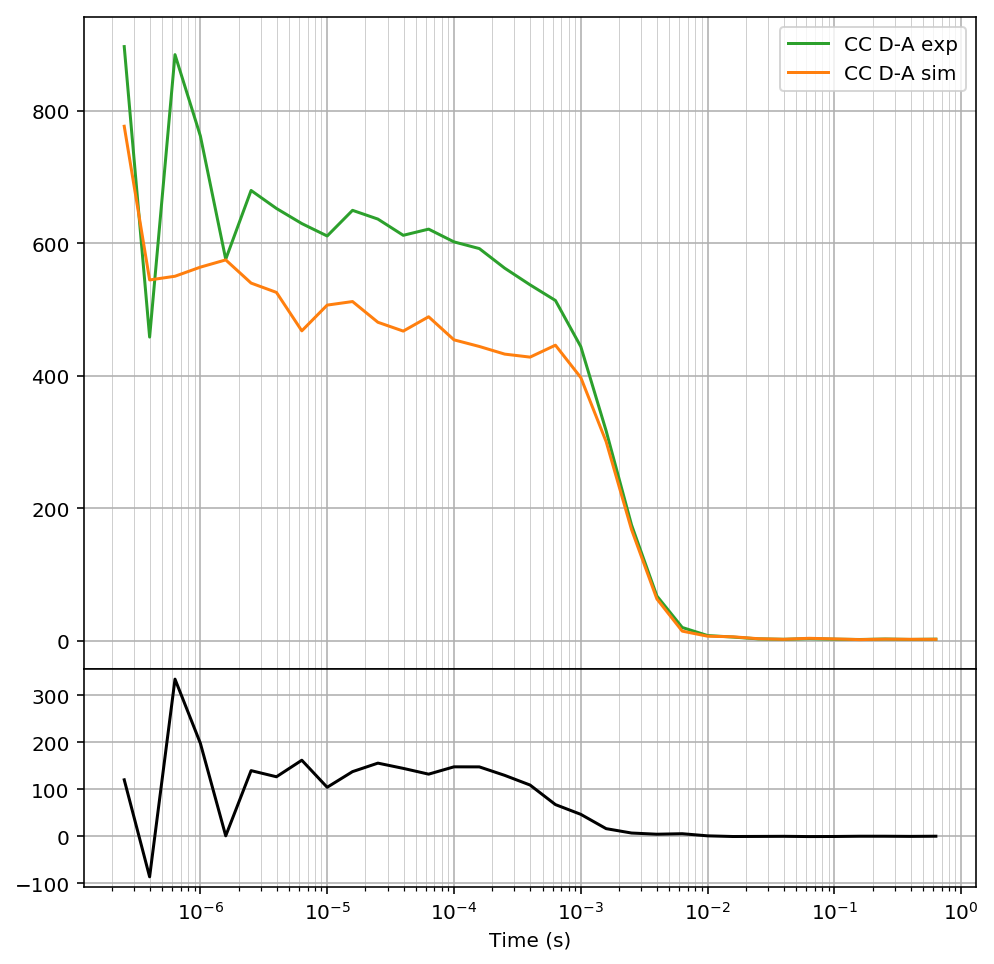

In [106]:
timelags = fcs_bins[:-1] * 1e-9
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(timelags, CC_DA_exp, color='C2', label='CC D-A exp')
ax[0].semilogx(timelags, CC_DA_sim, color='C1', label='CC D-A sim')
ax[1].plot(timelags, CC_DA_exp - CC_DA_sim, color='k')
ax[1].set_xlabel('Time (s)')
ax[0].legend()
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3);

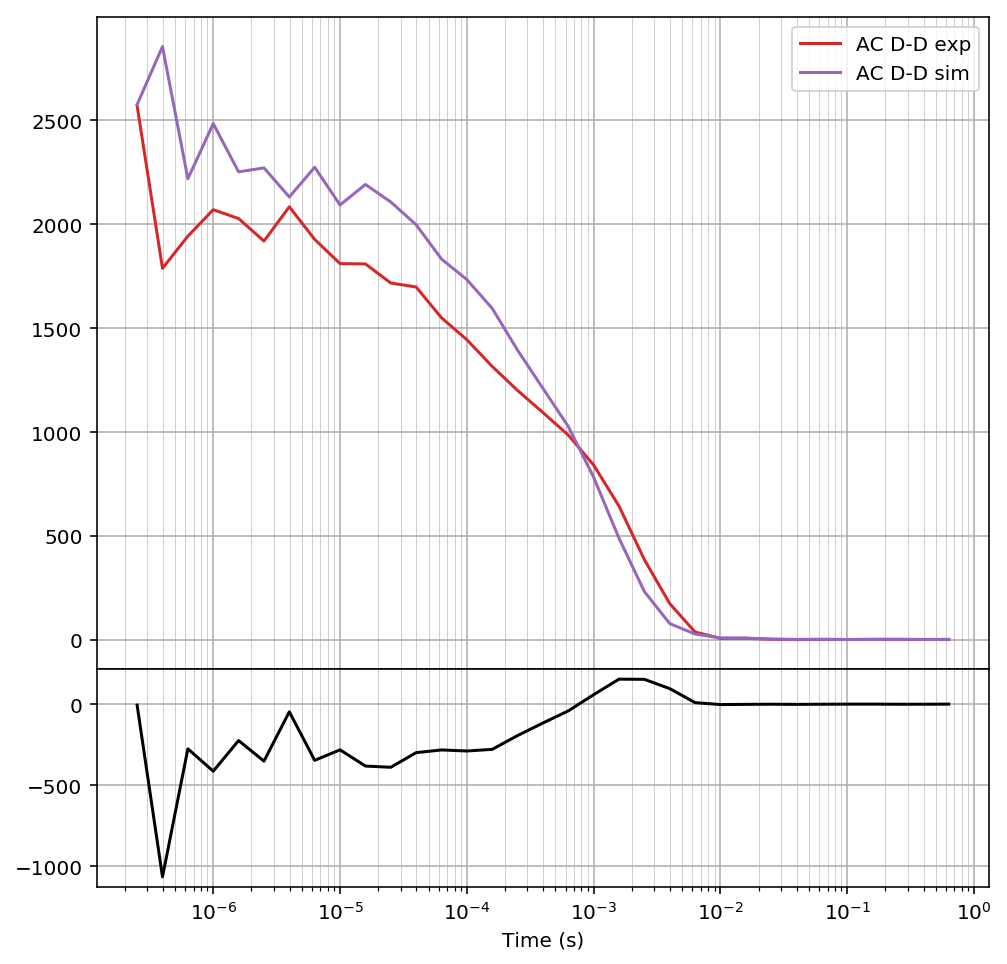

In [107]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(timelags, AC_DD_exp,  color='C3', label='AC D-D exp')
ax[0].semilogx(timelags, AC_DD_sim, color='C4', label='AC D-D sim')
ax[1].plot(timelags, AC_DD_exp - AC_DD_sim, color='k')
ax[1].set_xlabel('Time (s)')
ax[0].legend()
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3);

### Experimental FCS

In [ ]:
ts_unit = meta['timestamp_unit']
hw_unit = meta['timestamp_unit_hw']
scale = round(hw_unit / ts_unit)

In [ ]:
bins_per_dec = 5
bins = np.unique(np.round(pyc.make_loglags(0, 9, bins_per_dec)).astype('int'))
dbins = np.diff(bins)
timelags = bins[1:] * hw_unit
print(f'Min time-lag: {timelags_exp[0]},  Max time-lag: {timelags_exp[-1]},  # Time-lags: {len(timelags_exp)}')

DD = burstsph_sel.stream == 'DexDem'
DA = burstsph_sel.stream == 'DexAem'
t_exp = np.array(burstsph_sel.loc[DD, 'timestamp']) / scale
u_exp = np.array(burstsph_sel.loc[DA, 'timestamp']) / scale
nt_d = np.array(burstsph_sel.loc[DD, 'nanotime'])
nt_a = np.array(burstsph_sel.loc[DA, 'nanotime'])
t_exp2 = t_exp + nt_d * tcspc_unit * 1e9 / scale
u_exp2 = u_exp + nt_a * tcspc_unit * 1e9 / scale
CC_DA_exp_raw = pyc.pcorrelate(t_exp2, u_exp2, bins, normalize=False)
AC_DD_exp_raw = pyc.pcorrelate(t_exp2, t_exp2, bins, normalize=False)

CC_DA_exp2 = pyc.pcorrelate(t_exp2, u_exp2, bins, normalize=True)+1
AC_DD_exp2 = pyc.pcorrelate(t_exp2, t_exp2, bins, normalize=True)+1
Levitus_exp2 = AC_DD_exp2 / CC_DA_exp2;

DDs = burstsph_sim.stream == 'DexDem'
DAs = burstsph_sim.stream == 'DexAem'
t = np.array(burstsph_sim.loc[DDs, 'timestamp']) / scale
u = np.array(burstsph_sim.loc[DAs, 'timestamp']) / scale
nt_d = np.array(burstsph_sim.loc[DDs, 'nanotime'])
nt_a = np.array(burstsph_sim.loc[DAs, 'nanotime'])
t2 = t + nt_d * tcspc_unit * 1e9 / scale
u2 = u + nt_a * tcspc_unit * 1e9 / scale
CC_DA2 = pyc.pcorrelate(t2, u2, bins, normalize=True) + 1
AC_DD2 = pyc.pcorrelate(t2, t2, bins, normalize=True) + 1
Levitus2 = AC_DD2/CC_DA2

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags, CC_DA_exp2,  color='C2', label='CC D-A exp')
plt.semilogx(timelags, CC_DA2, color='C1', label='CC D-A sim')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0, 1000)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags, AC_DD_exp2, color='C3', label='AC D-D exp')
plt.semilogx(timelags, AC_DD2, color='C4', label='AC D-D sim')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7, 1)
plt.ylim(0, 6000)



# BVA

In [202]:
E_BVA = fret.calc_E_burst(burstsph_sim)

In [203]:
Dex_BVA = (burstsph_sim.stream == 'DexDem')|(burstsph_sim.stream ==  'DexAem')
burstsph_sim_Dex = burstsph_sim.loc[Dex_BVA]
burstsph_sim_Dex.head()

timestamp   nanotime      R_ph   A_ch  leak_ph  dir_ex_ph  \
burst ph                                                              
0     0   102993700   0.205495  4.379532   True     True      False   
      1   103160300   8.797799  0.720754   True    False       True   
      4   103753500   2.223321  2.411731   True    False       True   
      6   103802600   5.126663  1.872594   True    False      False   
      7   103848400  15.119501  2.894003  False    False      False   

          A_dark_ph  bg_ph  stream  nanotime_conv  nanotime_conv_unit  
burst ph                                                               
0     0       False  False  DexAem       0.337599                  23  
      1       False  False  DexAem      10.383048                 707  
      4       False  False  DexAem       2.766416                 188  
      6       False  False  DexAem       5.141341                 350  
      7       False   True  DexDem      15.354353                1046

In [204]:
n = 5
E_sub_std, E_sub_std_mean_bin, E_centers = bva.bva_bin_combo(
    burstsph_sim_Dex, n, num_sub_bursts_th=500)

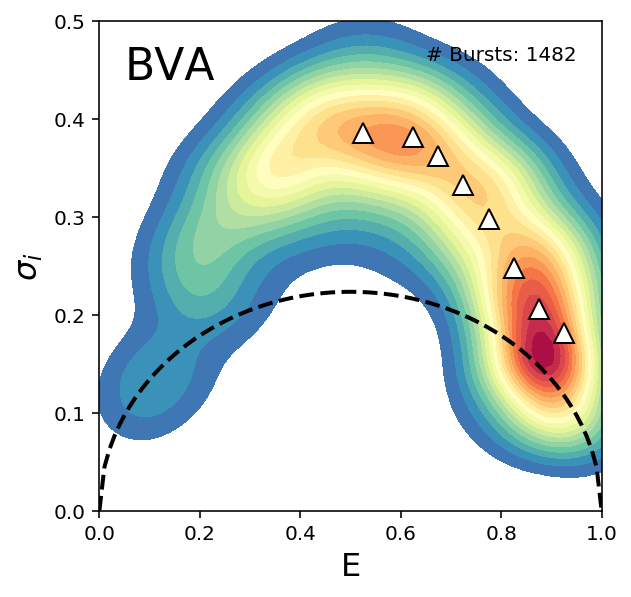

In [205]:
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
plt.plot(x, y, lw=2, color='k', ls='--')
im = sns.kdeplot(E_BVA, E_sub_std, 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.plot (E_centers, E_sub_std_mean_bin, 
          marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
plt.xlim(0,1)
plt.ylim(0,0.5)#np.sqrt(0.5**2/7)*2)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$\sigma_i$', fontsize=16);
plt.text(0.05, 0.95, 'BVA', va='top', fontsize=22, transform=plt.gca().transAxes)
plt.text(0.95, 0.95, '# Bursts: %d' % bursts.shape[0], 
         va='top', ha='right', transform=plt.gca().transAxes);

### Simulation vs. Experiment

In [206]:
n = 5
Dex = (burstsph_sel.stream == 'DexDem')|(burstsph_sel.stream ==  'DexAem')
burstsph_sel_Dex = burstsph_sel.loc[Dex]

E_sub_std_exp, E_sub_std_mean_bin_exp, E_centers_exp = depi.bva.bva_bin_combo(
    burstsph_sel_Dex, n, num_sub_bursts_th=500)

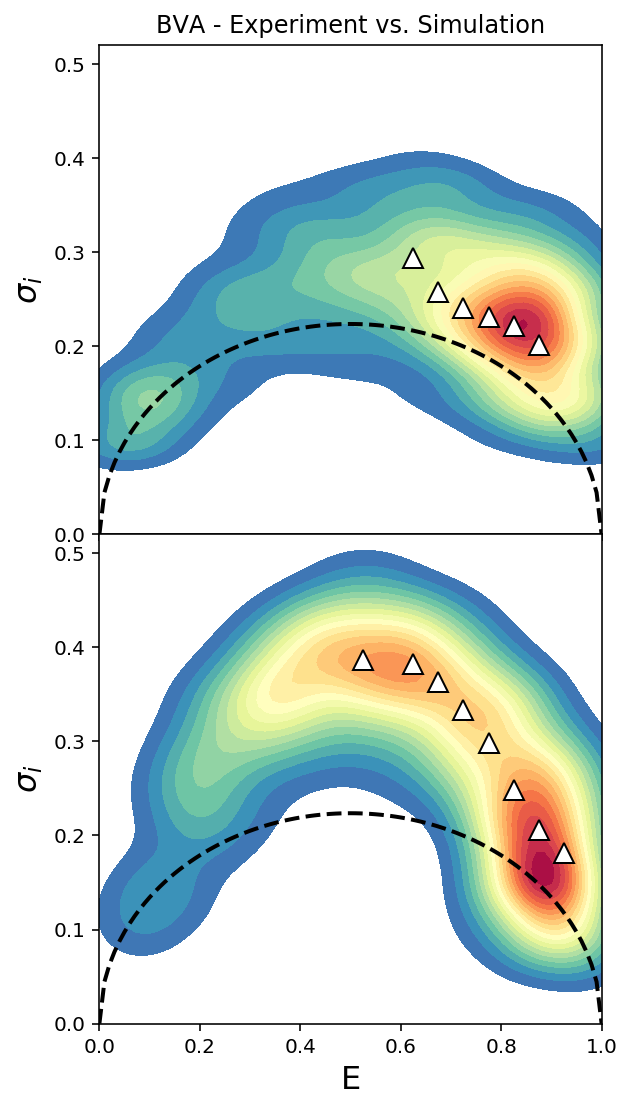

In [207]:
fig, ax = plt.subplots(2, 1, figsize=(4.5, 9), sharex=True)
plt.subplots_adjust(hspace=0)

x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)


sns.kdeplot(bursts_sel.E, E_sub_std_exp, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[0])
ax[0].plot (E_centers_exp, E_sub_std_mean_bin_exp, 
          marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)


sns.kdeplot(E_BVA, E_sub_std, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[1])
ax[1].plot (E_centers, E_sub_std_mean_bin, 
          marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)

for a in ax:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_xlim(0,1);
    a.set_ylim(0,0.52);
    a.set_ylabel(r'$\sigma_i$', fontsize=16);

ax[0].text(0.05, 0.95, 'BVA', va='top', fontsize=22, transform=plt.gca().transAxes);
ax[0].text(0.95, 0.95, '# Bursts: %d' % bursts_sel.shape[0], 
         va='top', ha='right', transform=plt.gca().transAxes);
ax[1].set_xlabel('E', fontsize=16);
ax[0].set_title('BVA - Experiment vs. Simulation');

# Global Simulation vs. Experiment

In [ ]:
## Experimental FCS

ts_unit = meta['timestamp_unit']
hw_unit = meta['timestamp_unit_hw']
ts_unit, hw_unit, round(hw_unit / ts_unit)

t_exp = np.array(burstsph_sel.loc[burstsph_sel.stream == 'DexDem', 'timestamp']) / round(hw_unit / ts_unit)
u_exp = np.array(burstsph_sel.loc[burstsph_sel.stream == 'DexAem', 'timestamp']) / round(hw_unit / ts_unit)

t_exp2 = t_exp + np.array((burstsph_sel.loc[DD, 'nanotime'] * tcspc_unit) / ts_unit)/ round(hw_unit / ts_unit)
u_exp2 = u_exp + np.array((burstsph_sel.loc[DA, 'nanotime'] * tcspc_unit) / ts_unit)/ round(hw_unit / ts_unit)

# compute lags in sec. then convert to timestamp units
bins_per_dec = 5
bins = np.unique(np.round(pyc.make_loglags(0, 9, bins_per_dec)).astype('int')) 
timelags_exp = bins[1:] * hw_unit
print(f'Min time-lag: {timelags_exp[0]},  Max time-lag: {timelags_exp[-1]},  # Time-lags: {len(timelags_exp)}')

CC_DA_exp = pyc.pcorrelate(t_exp, u_exp, bins, normalize=True)+1
AC_DD_exp = pyc.pcorrelate(t_exp, t_exp, bins, normalize=True)+1

CC_DA_exp2 = pyc.pcorrelate(t_exp2, u_exp2, bins, normalize=True)+1
AC_DD_exp2 = pyc.pcorrelate(t_exp2, t_exp2, bins, normalize=True)+1

fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, CC_DA_exp, drawstyle='steps-pre')
plt.semilogx(timelags_exp, CC_DA_exp2, drawstyle='steps-pre')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(1, 1200);

fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, AC_DD_exp, drawstyle='steps-pre')
plt.semilogx(timelags_exp, AC_DD_exp2, drawstyle='steps-pre')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(1, 1500);

Levitus_exp = AC_DD_exp / CC_DA_exp;

Levitus_exp2 = AC_DD_exp2 / CC_DA_exp2;fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, CC_DA_exp2, drawstyle='steps-pre', color='k')
plt.semilogx(timelags_s, CC_DA2, drawstyle='steps-pre', color='r')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0, 1000);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, AC_DD_exp2, drawstyle='steps-pre', color='k')
plt.semilogx(timelags_s, AC_DD2, drawstyle='steps-pre', color='r')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0, 5000);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, Levitus_exp2, drawstyle='steps-pre', color='k')
plt.semilogx(timelags_s, Levitus2, drawstyle='steps-pre', color='r')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0.5, 4);

## Save results for conditions

In [314]:
# Gaussian
R0 = params['R0']
del_t = params['δt']
R_mean = params['R_mean']#['R_mean']
R_sigma = params['R_sigma']#['R_sigma']
τ_D = params['τ_D']
D_fract = params['D_fract']
τ_A = params['τ_A']
# R_offset = params['offset']

In [315]:
# E_μ = np.zeros(len(params['R_mean']));
# for i, (R_m, R_s) in enumerate(zip(params['R_mean'], params['R_sigma'])):
#    E_μ[i] = depi.mean_E_from_gauss_PoR(R_m, R_s, R0)
Pr_obj = dd.distribution(params)
r_dist, Pr = Pr_obj.get_pdf()
E_μ = Pr_obj.mean_E(R0)#np.trapz(Pr/(1+((r_dist/R0)**6)), r_dist)
r_μ = np.trapz(r_dist * Pr, r_dist)

In [316]:
pr_μ = fret.uncorrect_E_gamma_leak_dir(E_μ, gamma=params['gamma'], leakage=params['lk'], 
                                       dir_ex_t=params['dir_ex_t'])

In [317]:
τ_D_mean = (τ_D[0]*D_fract[0]+τ_D[1]*D_fract[1])/(D_fract[0]+D_fract[1])
τ_D_mean2 = (τ_D[0]**2*D_fract[0]+τ_D[1]**2*D_fract[1])/(τ_D[0]*D_fract[0]+τ_D[1]*D_fract[1])

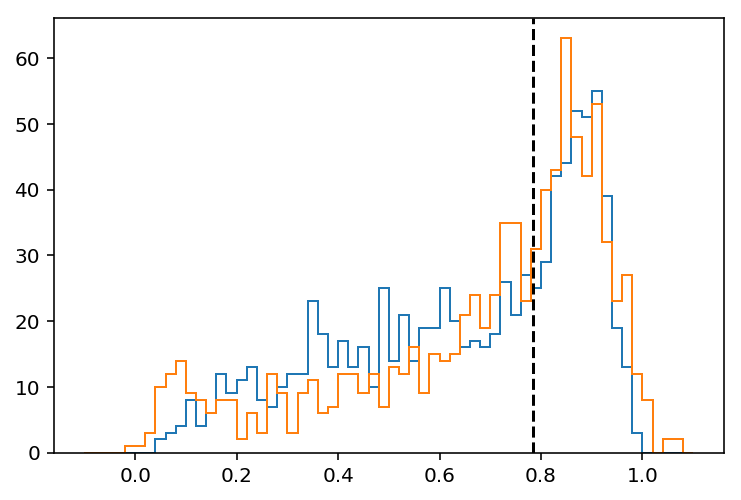

In [318]:
bins = np.arange(-0.1, 1.1, 0.02)
cnt_E_sim, bins, _ = plt.hist(E, bins=bins, alpha=1, label='E per burst (w/ shot-noise)', histtype='step')
# for i, (R_m, R_s) in enumerate(zip(params['R_mean'], params['R_sigma'])):
#     plt.axvline(pr_μ[i], ls='--', color='k', label=f'state{i}');
plt.axvline(pr_μ, ls='--', color='k');
cnt_E_exp, bins, _ = plt.hist(bursts_sel.E, bins=bins, alpha=1, label='E per burst (w/ shot-noise)', histtype='step');

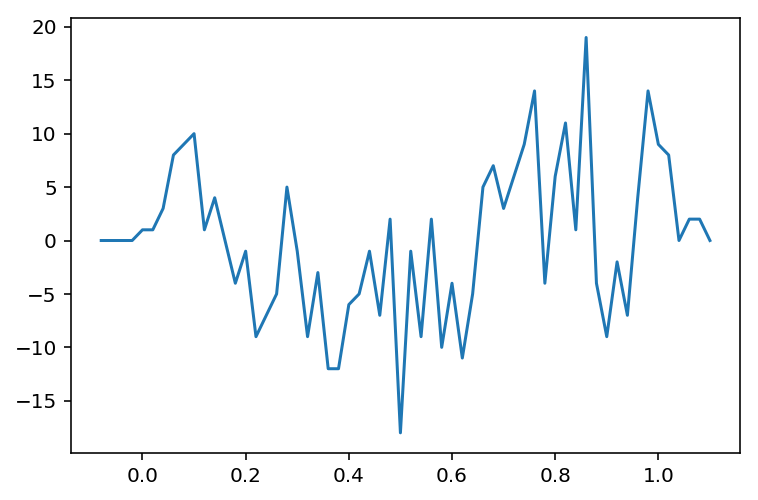

In [319]:
plt.plot(bins[1:], cnt_E_exp - cnt_E_sim)

In [320]:
np.mean(E), np.mean(bursts_sel.E)

(0.6513619944049236, 0.678418346512231)

In [321]:
np.std(E), np.std(bursts_sel.E)

(0.24137195081876958, 0.25703041264930077)

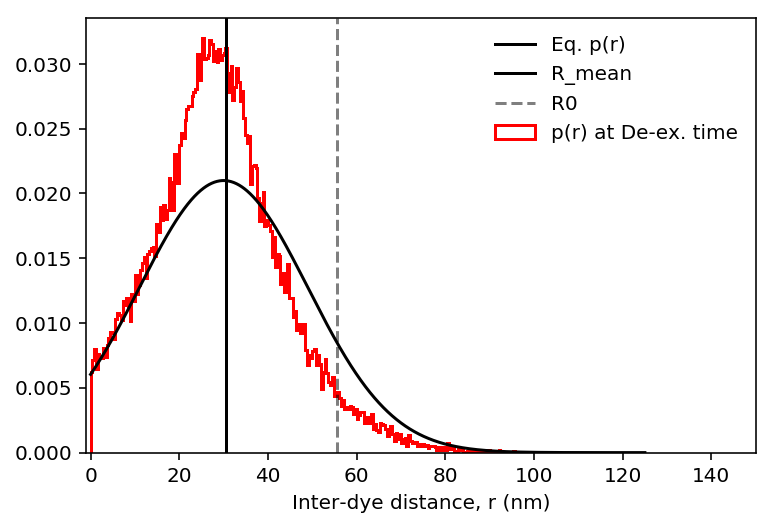

In [322]:
kw = dict(bins=r_dist[::4] * 10, density=True)
Pr_D_dex = burstsph_sim.R_ph
plt.hist(Pr_D_dex * 10, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=1.5, color='r', **kw);

plt.plot(r_dist * 10, Pr / 10, color='k', label='Eq. p(r)')
# plt.axvline(R_mean[0] * 10, color='k', label='R_mean');
plt.axvline(r_μ * 10, color='k', label='R_mean');
# plt.axvline(R_mean[0] * 10, color='k', label='R_mean');
# plt.axvline(R_mean[1] * 10, color='k', label='R_mean');
plt.axvline(R0 * 10, color='k', alpha=0.5, ls='--', label='R0');
plt.legend(frameon=False)
plt.xlim(-1, 150); 
plt.xlabel('Inter-dye distance, r (nm)');

In [323]:
burstsph_sim_d7_gaussian = burstsph_sim
# FRET histogram
E_d7_gaussian = E
E_μ_d7_gaussian = E_μ
r_dist_d7_gaussian = r_dist

# Fluorescence decays
time_axis_nt_d_d7_gaussian = time_axis
nt_d_d7_gaussian = nanot_hist_d_sim
nt_a_d7_gaussian = nanot_hist_a_sim

# Underlying distance distributions
Pr_d7_gaussian = Pr
Pr_D_dex_d7_gaussian = Pr_D_dex

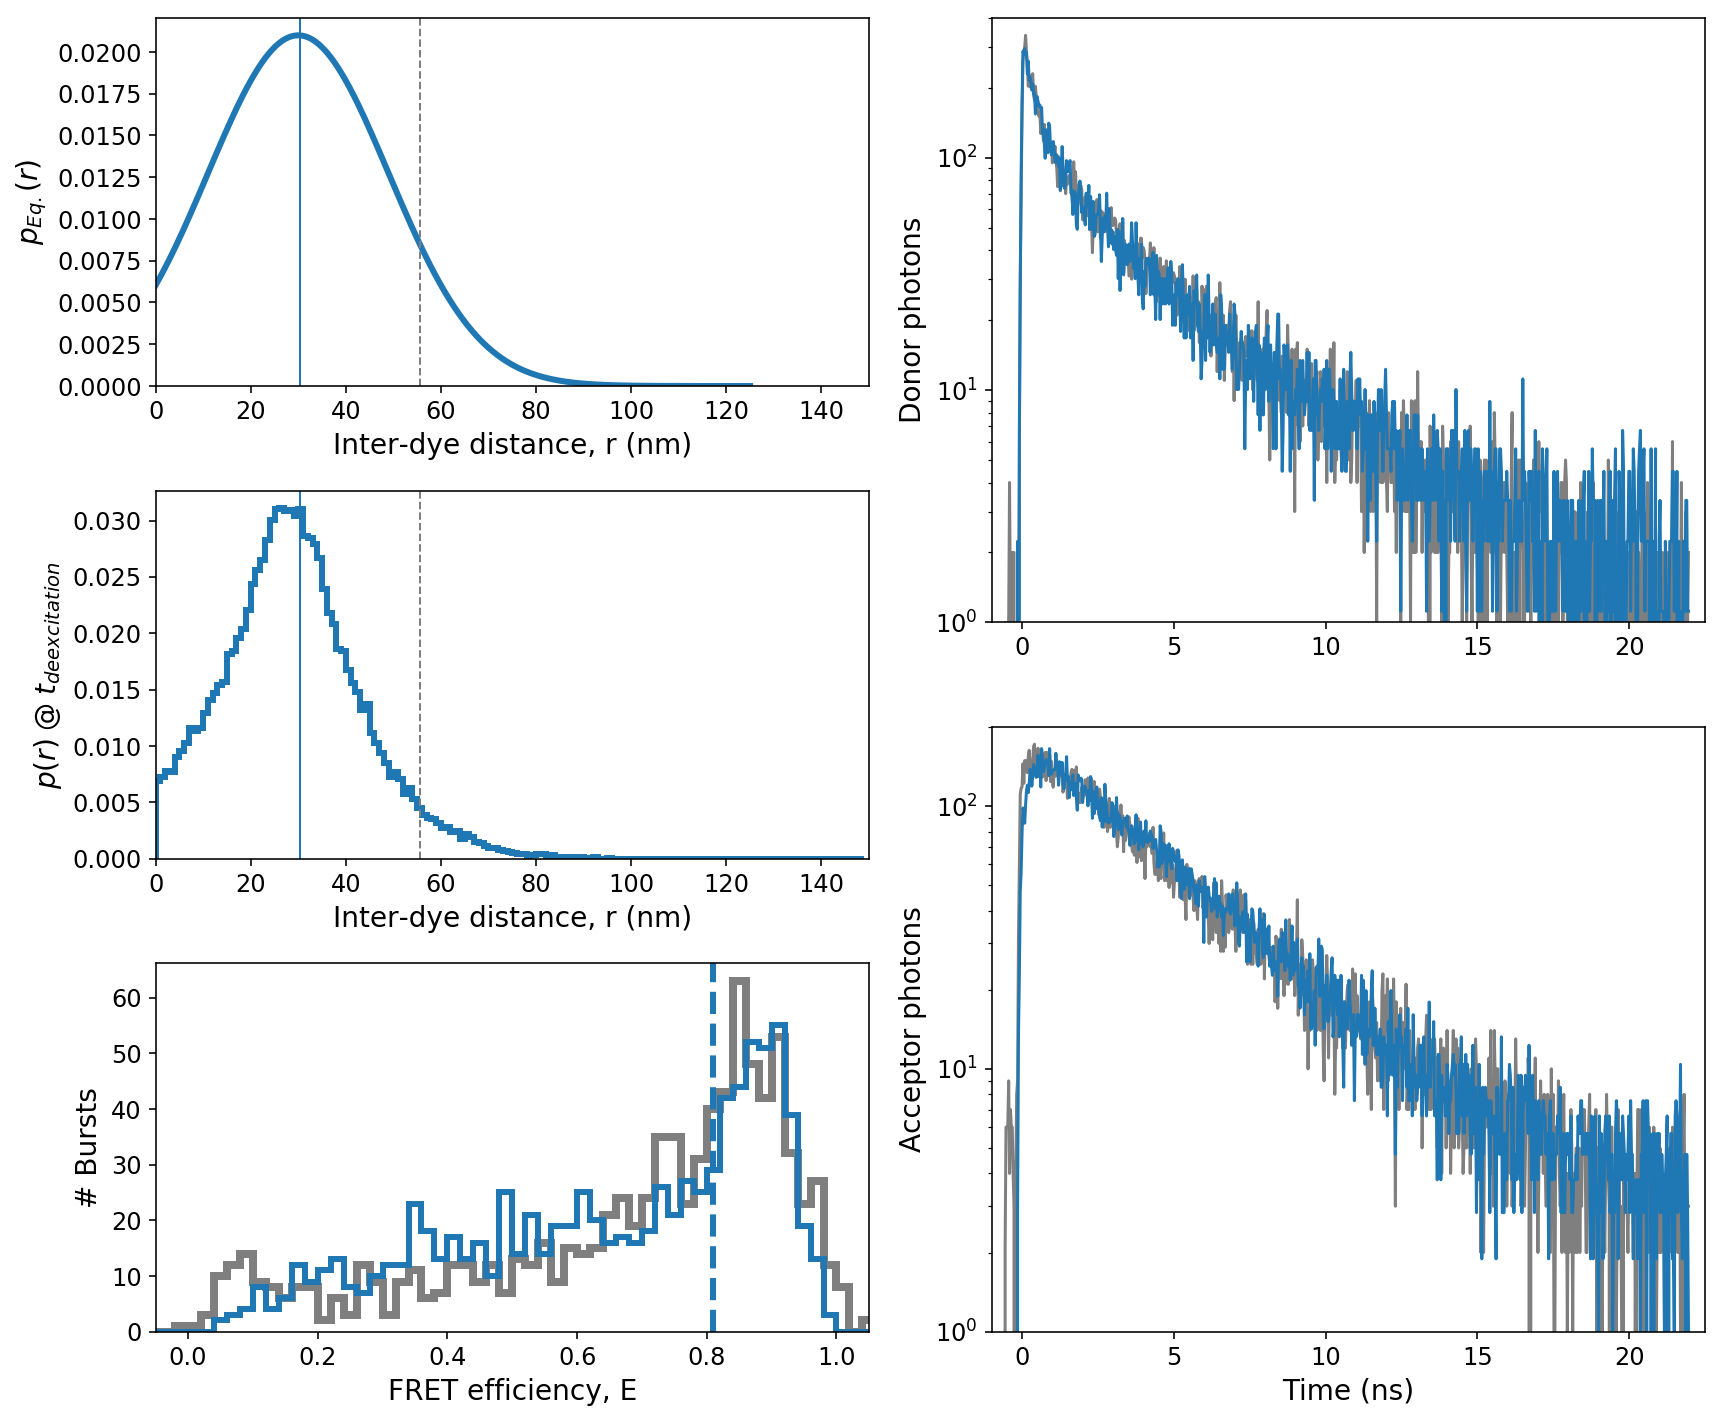

In [327]:
#d7 - single Gaussian population - best fit result
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 2, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,2), (0,0), colspan=1, rowspan=2)

plt.plot(r_dist_d7_gaussian * 10, Pr_d7_gaussian / 10, color=colors[0], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d7_gaussian * r_dist_d7_gaussian, r_dist_d7_gaussian) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,2), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_d7_gaussian * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=3, color=colors[0], **kw_dist);
plt.axvline(np.trapz(Pr_d7_gaussian * r_dist_d7_gaussian, r_dist_d7_gaussian) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,2), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(bursts_sel.E, bins=bins_E, linewidth=4, alpha=1, histtype='step', color='C7')
plt.hist(E_d7_gaussian, bins=bins_E, linewidth=3, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[0])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_d7_gaussian, ls='--', color=colors[0], linewidth=3);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,2), (0,1), colspan=1, rowspan=3)
plt.semilogy(time_axis, nanot_hist_d_exp, color='C7', label='DexDem')
plt.semilogy(time_axis, nanot_hist_d_sim, color=colors[0], label='DexDem sim')
plt.ylim(1, 400);
plt.xlim(-1, 22.5);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')




plt.subplot2grid((6,2), (3,1), colspan=1, rowspan=3)
plt.semilogy(time_axis, nanot_hist_a_exp, color='C7', label='DexAem')
plt.semilogy(time_axis, nanot_hist_a_sim, color=colors[0], label='DexAem sim')
plt.ylim(1, 200);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 22.5);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')



fig.set_size_inches(w=12,h=10)
plt.tight_layout()

#fig.savefig('d7_best_fit.png', dpi=600, bbox_inches='tight')

In [ ]:
burstsph_sim_d17_gaussian_D_2StatState = burstsph_sim
# FRET histogram
E_d17_gaussian_D_2StatState = E
E_μ_d17_gaussian_D_2StatState = pr_μ
r_dist_d17_gaussian_D_2StatState = r_dist

# Fluorescence decays
nt_d_d17_gaussian_D_2StatState = nt_d_conv
nt_a_d17_gaussian_D_2StatState = nt_a_conv

# Underlying distance distributions
Pr_d17_gaussian_2StatStateD = Pr
Pr_D_dex_d17_gaussian_D_2StatState = Pr_D_dex

# BVA
E_BVA_d17_gaussian_D_2StatState = E_BVA
E_sub_std_d17_gaussian_D_2StatState = E_sub_std
E_centers_d17_gaussian_D_2StatState = E_centers
E_sub_std_mean_bin_d17_gaussian_D_2StatState = E_sub_std_mean_bin

# FCS
CC_DA_d17_gaussian_D_2StatState = CC_DA2
AC_DD_d17_gaussian_D_2StatState = AC_DD2
Levitus_d17_gaussian_D_2StatState = Levitus2

In [ ]:
burstsph_sim_d17_gaussian_D_blink = burstsph_sim
# FRET histogram
E_d17_gaussian_D_blink = E
E_μ_d17_gaussian_D_blink = pr_μ
r_dist_d17_gaussian_D_blink = r_dist

# Fluorescence decays
nt_d_d17_gaussian_D_blink = nt_d_conv
nt_a_d17_gaussian_D_blink = nt_a_conv

# Underlying distance distributions
Pr_d17_gaussian__blinkD = Pr
Pr_D_dex_d17_gaussian_D_blink = Pr_D_dex

# BVA
E_BVA_d17_gaussian_D_blink = E_BVA
E_sub_std_d17_gaussian_D_blink = E_sub_std
E_centers_d17_gaussian__blinkD = E_centers
E_sub_std_mean_bin_d17_gaussian_D_blink = E_sub_std_mean_bin

# FCS
CC_DA_d17_gaussian_D_blink = CC_DA2
AC_DD_d17_gaussian_D_blink = AC_DD2
Levitus_d17_gaussian_D_blink = Levitus2

In [ ]:
burstsph_sim_d17_radial_gaussian_D_blink = burstsph_sim
# FRET histogram
E_d17_radial_gaussian_D_blink = E
E_μ_d17_radial_gaussian_D_blink = pr_μ
r_dist_d17_radial_gaussian_D_blink = r_dist

# Fluorescence decays
nt_d_d17_radial_gaussian_D_blink = nt_d_conv
nt_a_d17_radial_gaussian_D_blink = nt_a_conv

# Underlying distance distributions
Pr_d17_radial_gaussian__blinkD = Pr
Pr_D_dex_d17_radial_gaussian_D_blink = Pr_D_dex

# BVA
E_BVA_d17_radial_gaussian_D_blink = E_BVA
E_sub_std_d17_radial_gaussian_D_blink = E_sub_std
E_centers_d17_radial_gaussian__blinkD = E_centers
E_sub_std_mean_bin_d17_radial_gaussian_D_blink = E_sub_std_mean_bin

# FCS
CC_DA_d17_radial_gaussian_D_blink = CC_DA2
AC_DD_d17_radial_gaussian_D_blink = AC_DD2
Levitus_d17_radial_gaussian_D_blink = Levitus2

In [ ]:
burstsph_sim_d17_wlc_D_blink = burstsph_sim
# FRET histogram
E_d17_wlc_D_blink = E
E_μ_d17_wlc_D_blink = pr_μ
r_dist_d17_wlc_D_blink = r_dist

# Fluorescence decays
nt_d_d17_wlc_D_blink = nt_d_conv
nt_a_d17_wlc_D_blink = nt_a_conv

# Underlying distance distributions
Pr_d17_wlc__blinkD = Pr
Pr_D_dex_d17_wlc_D_blink = Pr_D_dex

# BVA
E_BVA_d17_wlc_D_blink = E_BVA
E_sub_std_d17_wlc_D_blink = E_sub_std
E_centers_d17_wlc__blinkD = E_centers
E_sub_std_mean_bin_d17_wlc_D_blink = E_sub_std_mean_bin

# FCS
CC_DA_d17_wlc_D_blink = CC_DA2
AC_DD_d17_wlc_D_blink = AC_DD2
Levitus_d17_wlc_D_blink = Levitus2

In [ ]:
burstsph_sim_d17_gaussian_D = burstsph_sim
# FRET histogram
E_d17_gaussian_D = E
E_μ_d17_gaussian_D = pr_μ
r_dist_d17_gaussian_D = r_dist

# Fluorescence decays
nt_d_d17_gaussian_D = nt_d_conv
nt_a_d17_gaussian_D = nt_a_conv

# Underlying distance distributions
Pr_d17_gaussian_D = Pr
Pr_D_dex_d17_gaussian_D = Pr_D_dex

# BVA
E_BVA_d17_gaussian_D = E_BVA
E_sub_std_d17_gaussian_D = E_sub_std
E_centers_d17_gaussian_D = E_centers
E_sub_std_mean_bin_d17_gaussian_D = E_sub_std_mean_bin

# FCS
CC_DA_d17_gaussian_D = CC_DA2
AC_DD_d17_gaussian_D = AC_DD2
Levitus_d17_gaussian_D = Levitus2

In [ ]:
burstsph_sim_d17_radial_gaussian_D = burstsph_sim
# FRET histogram
E_d17_radial_gaussian_D = E
E_μ_d17_radial_gaussian_D = pr_μ
r_dist_d17_radial_gaussian_D = r_dist

# Fluorescence decays
nt_d_d17_radial_gaussian_D = nt_d_conv
nt_a_d17_radial_gaussian_D = nt_a_conv

# Underlying distance distributions
Pr_d17_radial_gaussian_D = Pr
Pr_D_dex_d17_radial_gaussian_D = Pr_D_dex

# BVA
E_BVA_d17_radial_gaussian_D = E_BVA
E_sub_std_d17_radial_gaussian_D = E_sub_std
E_centers_d17_radial_gaussian_D = E_centers
E_sub_std_mean_bin_d17_radial_gaussian_D = E_sub_std_mean_bin

# FCS
CC_DA_d17_radial_gaussian_D = CC_DA2
AC_DD_d17_radial_gaussian_D = AC_DD2
Levitus_d17_radial_gaussian_D = Levitus2

In [ ]:
burstsph_sim_d17_wlc_D = burstsph_sim
# FRET histogram
E_d17_wlc_D = E
E_μ_d17_wlc_D = pr_μ
r_dist_d17_wlc_D = r_dist

# Fluorescence decays
nt_d_d17_wlc_D = nt_d_conv
nt_a_d17_wlc_D = nt_a_conv

# Underlying distance distributions
Pr_d17_wlc_D = Pr
Pr_D_dex_d17_wlc_D = Pr_D_dex

# BVA
E_BVA_d17_wlc_D = E_BVA
E_sub_std_d17_wlc_D = E_sub_std
E_centers_d17_wlc_D = E_centers
E_sub_std_mean_bin_d17_wlc_D = E_sub_std_mean_bin

# FCS
CC_DA_d17_wlc_D = CC_DA2
AC_DD_d17_wlc_D = AC_DD2
Levitus_d17_wlc_D = Levitus2

In [ ]:
burstsph_sim_d17_gaussian = burstsph_sim
# FRET histogram
E_d17_gaussian = E
E_μ_d17_gaussian = pr_μ
r_dist_d17_gaussian = r_dist

# Fluorescence decays
nt_d_d17_gaussian = nt_d_conv
nt_a_d17_gaussian = nt_a_conv

# Underlying distance distributions
Pr_d17_gaussian = Pr
Pr_D_dex_d17_gaussian = Pr_D_dex

# BVA
E_BVA_d17_gaussian = E_BVA
E_sub_std_d17_gaussian = E_sub_std
E_centers_d17_gaussian = E_centers
E_sub_std_mean_bin_d17_gaussian = E_sub_std_mean_bin

# FCS
CC_DA_d17_gaussian = CC_DA2
AC_DD_d17_gaussian = AC_DD2
Levitus_d17_gaussian = Levitus2

In [ ]:
burstsph_sim_d17_radial_gaussian = burstsph_sim
# FRET histogram
E_d17_radial_gaussian = E
E_μ_d17_radial_gaussian = pr_μ
r_dist_d17_radial_gaussian = r_dist

# Fluorescence decays
nt_d_d17_radial_gaussian = nt_d_conv
nt_a_d17_radial_gaussian = nt_a_conv

# Underlying distance distributions
Pr_d17_radial_gaussian = Pr
Pr_D_dex_d17_radial_gaussian = Pr_D_dex

# BVA
E_BVA_d17_radial_gaussian = E_BVA
E_sub_std_d17_radial_gaussian = E_sub_std
E_centers_d17_radial_gaussian = E_centers
E_sub_std_mean_bin_d17_radial_gaussian = E_sub_std_mean_bin

# FCS
CC_DA_d17_radial_gaussian = CC_DA2
AC_DD_d17_radial_gaussian = AC_DD2
Levitus_d17_radial_gaussian = Levitus2

In [ ]:
burstsph_sim_d17_wlc = burstsph_sim
# FRET histogram
E_d17_wlc = E
E_μ_d17_wlc = pr_μ
r_dist_d17_wlc = r_dist

# Fluorescence decays
nt_d_d17_wlc = nt_d_conv
nt_a_d17_wlc = nt_a_conv

# Underlying distance distributions
Pr_d17_wlc = Pr
Pr_D_dex_d17_wlc = Pr_D_dex

# BVA
E_BVA_d17_wlc = E_BVA
E_sub_std_d17_wlc = E_sub_std
E_centers_d17_wlc = E_centers
E_sub_std_mean_bin_d17_wlc = E_sub_std_mean_bin

# FCS
CC_DA_d17_wlc = CC_DA2
AC_DD_d17_wlc = AC_DD2
Levitus_d17_wlc = Levitus2

In [ ]:
burstsph_sim_d7_radial_gaussian = burstsph_sim
# FRET histogram
E_d7_radial_gaussian = E
E_μ_d7_radial_gaussian = E_μ
r_dist_d7_radial_gaussian = r_dist

# Fluorescence decays
nt_d_d7_radial_gaussian = nt_d_conv
nt_a_d7_radial_gaussian = nt_a_conv

# Underlying distance distributions
Pr_d7_radial_gaussian = Pr
Pr_D_dex_d7_radial_gaussian = Pr_D_dex

# BVA
E_BVA_d7_radial_gaussian = E_BVA
E_sub_std_d7_radial_gaussian = E_sub_std
E_centers_d7_radial_gaussian = E_centers
E_sub_std_mean_bin_d7_radial_gaussian = E_sub_std_mean_bin

# FCS
CC_DA_d7_radial_gaussian = CC_DA
AC_DD_d7_radial_gaussian = AC_DD
Levitus_d7_radial_gaussian = Levitus

In [ ]:
burstsph_sim_d7_wlc = burstsph_sim
# FRET histogram
E_d7_wlc = E
E_μ_d7_wlc = E_μ
r_dist_d7_wlc = r_dist

# Fluorescence decays
nt_d_d7_wlc = nt_d_conv
nt_a_d7_wlc = nt_a_conv

# Underlying distance distributions
Pr_d7_wlc = Pr
Pr_D_dex_d7_wlc = Pr_D_dex

# BVA
E_BVA_d7_wlc = E_BVA
E_sub_std_d7_wlc = E_sub_std
E_centers_d7_wlc = E_centers
E_sub_std_mean_bin_d7_wlc = E_sub_std_mean_bin

# FCS
CC_DA_d7_wlc = CC_DA
AC_DD_d7_wlc = AC_DD
Levitus_d7_wlc = Levitus

In [ ]:
burstsph_sim_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = burstsph_sim
# FRET histogram
E_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E
E_μ_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = nt_d
nt_a_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E
E_μ_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = nt_d
nt_a_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_centers
E_sub_std_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E
E_μ_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = nt_d
nt_a_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E
E_μ_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = nt_d
nt_a_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = burstsph_sim
# FRET histogram
E_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E
E_μ_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = burstsph_sim
# FRET histogram
E_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E
E_μ_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = burstsph_sim
# FRET histogram
E_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E
E_μ_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = Levitus

# Compare BVA & Seidel maps

In [ ]:
num_of_panels = 4
num_of_columns = 3
square_size = 3
fig, ax = plt.subplots(num_of_panels, num_of_columns, figsize=(square_size * num_of_columns, 
            square_size * num_of_panels), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0.4)



sns.kdeplot(E_BVA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[0,0])
ax[0,0].text(0.1, 0.1, r'$\tau_c$ $=$ $50$ $ns$', transform=ax[0,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[0,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
                 E_sub_std_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[1,0])
ax[1,0].text(0.1, 0.1, r'$\tau_c$ $=$ $8$ $ns$', transform=ax[1,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[1,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
                 E_sub_std_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[2,0])
ax[2,0].text(0.1, 0.1, r'$\tau_c$ $=$ $2.5$ $ns$', transform=ax[2,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[2,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
                 E_sub_std_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[3,0])
ax[3,0].text(0.1, 0.1, r'$\tau_c$ $=$ $800$ $ps$', transform=ax[3,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[3,0].set_ylim(-0.05,1.05, 0.2);




im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,1])
ax[0,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,1])
ax[1,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,1])
ax[2,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,1])
ax[3,1].set_ylim(-0.05,1.05, 0.2);


im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,2])
ax[0,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,2])
ax[1,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,2])
ax[2,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,2])
ax[3,2].set_ylim(-0.05,1.05, 0.2);


x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
for a in ax[:,0]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(0, 0.39, 0.1);
    a.set_ylabel(r'$\sigma_i$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_D * (1 - x)
for a in ax[:,1]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(-0.05 * τ_D,1.05 * τ_D, 0.2 * τ_D);
    a.set_ylabel(r'$\tau_D$ $(ns)$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_A + τ_D * (1 - x)
for a in ax[:,2]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(τ_A + -0.05 * τ_D,τ_A + 1.05 * τ_D, τ_A + 0.2 * τ_D);
    a.set_ylabel(r'$\tau_A$ $(ns)$', fontsize=16);
    a.grid(True);

for a in ax[3,:]:
    a.set_xlabel('E', fontsize=16);

fig.savefig('sim_1state_fastDynamics_BVA_Seidel.png', dpi=600, bbox_inches='tight')

In [ ]:
num_of_panels = 5
num_of_columns = 3
square_size = 3
fig, ax = plt.subplots(num_of_panels, num_of_columns, figsize=(square_size * num_of_columns, 
            square_size * num_of_panels), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0.4)



sns.kdeplot(E_BVA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[0,0])
ax[0,0].text(0.1, 0.1, r'$\tau_c$ $=$ $50$ $ns$', transform=ax[0,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[0,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[1,0])
ax[1,0].text(0.1, 0.1, r'$\tau_c$ $=$ $200$ $ns$', transform=ax[1,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[1,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[2,0])
ax[2,0].text(0.1, 0.1, r'$\tau_c$ $=$ $1$ $\mu$$s$', transform=ax[2,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[2,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[3,0])
ax[3,0].text(0.1, 0.1, r'$\tau_c$ $=$ $10$ $\mu$$s$', transform=ax[3,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[3,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[4,0])
ax[4,0].text(0.1, 0.1, r'$\tau_c$ $=$ $100$ $\mu$$s$', transform=ax[4,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[4,0].set_ylim(-0.05,1.05, 0.2);




im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,1])
ax[0,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,1])
ax[1,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,1])
ax[2,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,1])
ax[3,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[4,1])
ax[4,1].set_ylim(-0.05,1.05, 0.2);


im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,2])
ax[0,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,2])
ax[1,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,2])
ax[2,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,2])
ax[3,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[4,2])
ax[4,2].set_ylim(-0.05,1.05, 0.2);


x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
for a in ax[:,0]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(0, 0.39, 0.1);
    a.set_ylabel(r'$\sigma_i$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_D * (1 - x)
for a in ax[:,1]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(-0.05 * τ_D,1.05 * τ_D, 0.2 * τ_D);
    a.set_ylabel(r'$\tau_D$ $(ns)$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_A + τ_D * (1 - x)
for a in ax[:,2]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(τ_A + -0.05 * τ_D,τ_A + 1.05 * τ_D, τ_A + 0.2 * τ_D);
    a.set_ylabel(r'$\tau_A$ $(ns)$', fontsize=16);
    a.grid(True);

for a in ax[4,:]:
    a.set_xlabel('E', fontsize=16);

fig.savefig('sim_1state_slowDynamics_BVA_Seidel.png', dpi=600, bbox_inches='tight')

In [ ]:
num_of_panels = 6
num_of_columns = 3
square_size = 3
fig, ax = plt.subplots(num_of_panels, num_of_columns, figsize=(square_size * num_of_columns, 
            square_size * num_of_panels), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0.4)



sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[0,0])
ax[0,0].text(0.1, 0.1, r'$\tau_r$ $=$ $1$ $\mu$$s$', transform=ax[0,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[0,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[1,0])
ax[1,0].text(0.1, 0.1, r'$\tau_r$ $=$ $10$ $\mu$$s$', transform=ax[1,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[1,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[2,0])
ax[2,0].text(0.1, 0.1, r'$\tau_r$ $=$ $100$ $\mu$$s$', transform=ax[2,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[2,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[3,0])
ax[3,0].text(0.1, 0.1, r'$\tau_r$ $=$ $1$ $ms$', transform=ax[3,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[3,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[4,0])
ax[4,0].text(0.1, 0.1, r'$\tau_r$ $=$ $10$ $ms$', transform=ax[4,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[4,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[5,0])
ax[5,0].text(0.1, 0.1, r'$\tau_r$ $=$ $100$ $ms$', transform=ax[5,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[5,0].set_ylim(-0.05,1.05, 0.2);




im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,1])
ax[0,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,1])
ax[1,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,1])
ax[2,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,1])
ax[3,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[4,1])
ax[4,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[5,1])
ax[5,1].set_ylim(-0.05,1.05, 0.2);


im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,2])
ax[0,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,2])
ax[1,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,2])
ax[2,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,2])
ax[3,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[4,2])
ax[4,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[5,2])
ax[5,2].set_ylim(-0.05,1.05, 0.2);


x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
for a in ax[:,0]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(0, 0.39, 0.1);
    a.set_ylabel(r'$\sigma_i$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_D * (1 - x)
for a in ax[:,1]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(-0.05 * τ_D,1.05 * τ_D, 0.2 * τ_D);
    a.set_ylabel(r'$\tau_D$ $(ns)$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_A + τ_D * (1 - x)
for a in ax[:,2]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(τ_A + -0.05 * τ_D,τ_A + 1.05 * τ_D, τ_A + 0.2 * τ_D);
    a.set_ylabel(r'$\tau_A$ $(ns)$', fontsize=16);
    a.grid(True);

for a in ax[5,:]:
    a.set_xlabel('E', fontsize=16);

fig.savefig('sim_2state_slowDynamics_BVA_Seidel.png', dpi=600, bbox_inches='tight')

# Combined figures

In [228]:
from matplotlib import gridspec

In [ ]:
#d17 - single population - Diffusion of tauC = 0.5 ns - 5% blinking at 100 us
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)

plt.plot(r_dist_d17_gaussian_D * 10, Pr_d17_gaussian_D / 10, color=colors[0], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_gaussian_D * r_dist_d17_gaussian_D, r_dist_d17_gaussian_D) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_gaussian_D_blink * 10, Pr_d17_gaussian_D_blink / 10, color=colors[1], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_gaussian_D_blink * r_dist_d17_gaussian_D_blink, r_dist_d17_gaussian_D_blink) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

# plt.plot(r_dist_d17_wlc_D * 10, Pr_d17_wlc_D / 10, color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
# plt.axvline(np.trapz(Pr_d17_wlc_D * r_dist_d17_wlc_D, r_dist_d17_wlc_D) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_d17_gaussian_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=3, color=colors[0], **kw_dist);
plt.axvline(np.trapz(Pr_d17_gaussian_D * r_dist_d17_gaussian_D, r_dist_d17_gaussian_D) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_gaussian_D_blink * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(np.trapz(Pr_d17_gaussian_D_blink * r_dist_d17_gaussian_D_blink, r_dist_d17_gaussian_D_blink) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

# plt.hist(Pr_D_dex_d17_wlc_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
# plt.axvline(np.trapz(Pr_d17_wlc_D * r_dist_d17_wlc_D, r_dist_d17_wlc_D) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(bursts_sel.E, bins=bins_E, linewidth=4, alpha=1, histtype='step', color='C7')
plt.hist(E_d17_gaussian_D, bins=bins_E, linewidth=3, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_d17_gaussian_D_blink, bins=bins_E, linewidth=2, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[1])
# plt.hist(E_d17_wlc_D, bins=bins_E, linewidth=1, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[2])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_d17_gaussian_D, ls='--', color=colors[0], linewidth=3);
plt.axvline(E_μ_d17_gaussian_D_blink[0], ls='--', color=colors[1], linewidth=2);
plt.axvline(E_μ_d17_gaussian_D_blink[1], ls='--', color=colors[1], linewidth=2);
# plt.axvline(E_μ_d17_wlc_D, ls='--', color=colors[2], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nanotimes_d_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_d_d17_gaussian_D, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_gaussian_D_blink, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
# plt.hist(nt_d_d17_wlc_D, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 5000);
plt.xlim(-1, 22.5);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nanotimes_a_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_a_d17_gaussian_D, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_gaussian_D_blink, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
# plt.hist(nt_a_d17_wlc_D, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 1000);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 22.5);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, CC_DA_exp2, color='C7', linewidth=2)
plt.semilogx(timelags_s, CC_DA_d17_gaussian_D, color=colors[0], linewidth=1.5, label='miu=65.14 A; sigma=8 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_gaussian_D_blink, color=colors[1], linewidth=1.5, label='miu=68.07 A; sigma=20 A; tauc=50 ns')
# plt.semilogx(timelags_s, CC_DA_d17_wlc_D, color=colors[2], linewidth=2, label='miu=[49, 86.81] A; sigma=[8, 20] A; tauc=50 ns; taurel=10 us')
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, AC_DD_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_gaussian_D, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_gaussian_D_blink, color=colors[1], linewidth=1.5)
# plt.semilogx(timelags_s, AC_DD_d17_wlc_D, color=colors[2], linewidth=2)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1,1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, Levitus_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_gaussian_D, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_gaussian_D_blink, color=colors[1], linewidth=1.5)
# plt.semilogx(timelags_s, Levitus_d17_wlc_D, color=colors[2], linewidth=2)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()


#fig.savefig('sim_different_shapes.png', dpi=600, bbox_inches='tight')

In [ ]:
#d17 - single population - Diffusion of tauC = 0.5 ns - no blinking
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)

plt.plot(r_dist_d17_gaussian_D * 10, Pr_d17_gaussian_D / 10, color=colors[0], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_gaussian_D * r_dist_d17_gaussian_D, r_dist_d17_gaussian_D) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_radial_gaussian_D * 10, Pr_d17_radial_gaussian_D / 10, color=colors[1], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_radial_gaussian_D * r_dist_d17_radial_gaussian_D, r_dist_d17_radial_gaussian_D) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_wlc_D * 10, Pr_d17_wlc_D / 10, color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_wlc_D * r_dist_d17_wlc_D, r_dist_d17_wlc_D) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_d17_gaussian_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=3, color=colors[0], **kw_dist);
plt.axvline(np.trapz(Pr_d17_gaussian_D * r_dist_d17_gaussian_D, r_dist_d17_gaussian_D) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_radial_gaussian_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(np.trapz(Pr_d17_radial_gaussian_D * r_dist_d17_radial_gaussian_D, r_dist_d17_radial_gaussian_D) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_wlc_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(np.trapz(Pr_d17_wlc_D * r_dist_d17_wlc_D, r_dist_d17_wlc_D) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(bursts_sel.E, bins=bins_E, linewidth=4, alpha=1, histtype='step', color='C7')
plt.hist(E_d17_gaussian_D, bins=bins_E, linewidth=3, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_d17_radial_gaussian_D, bins=bins_E, linewidth=2, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_d17_wlc_D, bins=bins_E, linewidth=1, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[2])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_d17_gaussian_D, ls='--', color=colors[0], linewidth=3);
plt.axvline(E_μ_d17_radial_gaussian_D, ls='--', color=colors[1], linewidth=2);
plt.axvline(E_μ_d17_wlc_D, ls='--', color=colors[2], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nanotimes_d_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_d_d17_gaussian_D, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_radial_gaussian_D, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_wlc_D, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 5000);
plt.xlim(-1, 22.5);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nanotimes_a_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_a_d17_gaussian_D, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_radial_gaussian_D, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_wlc_D, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 1000);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 22.5);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, CC_DA_exp2, color='C7', linewidth=2)
plt.semilogx(timelags_s, CC_DA_d17_gaussian_D, color=colors[0], linewidth=1.5, label='miu=65.14 A; sigma=8 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_radial_gaussian_D, color=colors[1], linewidth=1.5, label='miu=68.07 A; sigma=20 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_wlc_D, color=colors[2], linewidth=2, label='miu=[49, 86.81] A; sigma=[8, 20] A; tauc=50 ns; taurel=10 us')
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, AC_DD_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_gaussian_D, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_radial_gaussian_D, color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_wlc_D, color=colors[2], linewidth=2)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1,1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, Levitus_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_gaussian_D, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_radial_gaussian_D, color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_wlc_D, color=colors[2], linewidth=2)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()

#fig.savefig('sim_different_shapes.png', dpi=600, bbox_inches='tight')

In [ ]:
#d17 - single population - no diffusion - no blinking
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)

plt.plot(r_dist_d17_gaussian * 10, Pr_d17_gaussian / 10, color=colors[0], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_gaussian * r_dist_d17_gaussian, r_dist_d17_gaussian) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_radial_gaussian * 10, Pr_d17_radial_gaussian / 10, color=colors[1], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_radial_gaussian * r_dist_d17_radial_gaussian, r_dist_d17_radial_gaussian) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_wlc * 10, Pr_d17_wlc / 10, color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_wlc * r_dist_d17_wlc, r_dist_d17_wlc) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_d17_gaussian * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=3, color=colors[0], **kw_dist);
plt.axvline(np.trapz(Pr_d17_gaussian * r_dist_d17_gaussian, r_dist_d17_gaussian) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_radial_gaussian * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(np.trapz(Pr_d17_radial_gaussian * r_dist_d17_radial_gaussian, r_dist_d17_radial_gaussian) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_wlc * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(np.trapz(Pr_d17_wlc * r_dist_d17_wlc, r_dist_d17_wlc) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(bursts_sel.E, bins=bins_E, linewidth=4, alpha=1, histtype='step', color='C7')
plt.hist(E_d17_gaussian, bins=bins_E, linewidth=3, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_d17_radial_gaussian, bins=bins_E, linewidth=2, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_d17_wlc, bins=bins_E, linewidth=1, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[2])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_d17_gaussian, ls='--', color=colors[0], linewidth=3);
plt.axvline(E_μ_d17_radial_gaussian, ls='--', color=colors[1], linewidth=2);
plt.axvline(E_μ_d17_wlc, ls='--', color=colors[2], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nanotimes_d_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_d_d17_gaussian, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_radial_gaussian, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_wlc, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 5000);
plt.xlim(-1, 22.5);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nanotimes_a_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_a_d17_gaussian, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_radial_gaussian, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_wlc, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 1000);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 22.5);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, CC_DA_exp2, color='C7', linewidth=2)
plt.semilogx(timelags_s, CC_DA_d17_gaussian, color=colors[0], linewidth=1.5, label='miu=65.14 A; sigma=8 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_radial_gaussian, color=colors[1], linewidth=1.5, label='miu=68.07 A; sigma=20 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_wlc, color=colors[2], linewidth=2, label='miu=[49, 86.81] A; sigma=[8, 20] A; tauc=50 ns; taurel=10 us')
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, AC_DD_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_gaussian, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_radial_gaussian, color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_wlc, color=colors[2], linewidth=2)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1,1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, Levitus_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_gaussian, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_radial_gaussian, color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_wlc, color=colors[2], linewidth=2)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()

#fig.savefig('sim_different_shapes.png', dpi=600, bbox_inches='tight')

In [ ]:
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nanotimes_d_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_d_d17_radial_gaussian, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);


In [ ]:
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)
plt.plot(np.arange(1, 150, 1), Pr_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
         color=colors[0], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(65.14, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
         color=colors[1], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
         color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(49, color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
         histtype='step', alpha=1, lw=2, color=colors[0], **kw_dist);
plt.axvline(65.14, color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(68.07, color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(49, color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(E_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=4, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=2, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[2])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, ls='--', color=colors[0], 
            linewidth=3);
plt.axvline(E_μ_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, ls='--', color=colors[1], 
            linewidth=2);
plt.axvline(E_μ_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4[0], ls='--', color=colors[2], 
            linewidth=1);
plt.axvline(E_μ_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4[1], ls='--', color=colors[2], 
            linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nt_d_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 10000 * 3);
plt.xlim(-1, 35);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nt_a_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 2000 * 3);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 35);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, CC_DA_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=6, label='miu=65.14 A; sigma=8 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=4, label='miu=68.07 A; sigma=20 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=2, label='miu=[49, 86.81] A; sigma=[8, 20] A; tauc=50 ns; taurel=10 us')
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, AC_DD_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=6)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=4)
plt.semilogx(timelags_s, AC_DD_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=2)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, Levitus_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=6)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=4)
plt.semilogx(timelags_s, Levitus_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=2)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()

fig.savefig('sim_different_shapes.png', dpi=600, bbox_inches='tight')

In [ ]:
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
         color=colors[0], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
         color=colors[1], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(70.95, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
         color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(74.5, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
         color=colors[3], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(79.28, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
         histtype='step', alpha=1, lw=2, color=colors[0], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(70.95, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(74.5, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[3], **kw_dist);
plt.axvline(79.28, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(E_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[2])
plt.hist(E_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[3])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, ls='--', color=colors[0], linewidth=1);
plt.axvline(E_μ_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, ls='--', color=colors[1], linewidth=1);
plt.axvline(E_μ_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, ls='--', color=colors[2], linewidth=1);
plt.axvline(E_μ_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, ls='--', color=colors[3], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nt_d_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, **kws_tr);
plt.hist(nt_d_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=9, **kws_tr);
plt.hist(nt_d_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=9, **kws_tr);
plt.hist(nt_d_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=9, **kws_tr);
plt.ylim(1, 10000 * 3);
plt.xlim(-1, 35);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nt_a_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, **kws_tr);
plt.hist(nt_a_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=9, **kws_tr);
plt.hist(nt_a_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=9, **kws_tr);
plt.hist(nt_a_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=9, **kws_tr);
plt.ylim(1, 2000 * 3);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 35);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=7)
plt.semilogx(timelags_s, CC_DA_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=5)
plt.semilogx(timelags_s, CC_DA_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=3)
plt.semilogx(timelags_s, CC_DA_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1)
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=7)
plt.semilogx(timelags_s, AC_DD_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=5)
plt.semilogx(timelags_s, AC_DD_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=3)
plt.semilogx(timelags_s, AC_DD_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=7)
plt.semilogx(timelags_s, Levitus_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=5)
plt.semilogx(timelags_s, Levitus_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=3)
plt.semilogx(timelags_s, Levitus_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()

fig.savefig('sim_1state_fastDynamics.png', dpi=600, bbox_inches='tight')

In [ ]:
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
         color=colors[0], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
         color=colors[1], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
         color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
         color=colors[3], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
         color=colors[4], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0, 0.023, 0.01); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
         histtype='step', alpha=1, lw=2, color=colors[0], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[3], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[4], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0, 0.023, 0.01); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(E_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=5.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=4, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=2.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[2])
plt.hist(E_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=2, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[3])
plt.hist(E_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[4])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, ls='--', color=colors[0], linewidth=3);
plt.axvline(E_μ_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, ls='--', color=colors[1], linewidth=2.5);
plt.axvline(E_μ_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, ls='--', color=colors[2], linewidth=2);
plt.axvline(E_μ_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, ls='--', color=colors[3], linewidth=1.5);
plt.axvline(E_μ_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, ls='--', color=colors[4], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nt_d_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=7, **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=5, **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=3, **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
           color=colors[4], linewidth=1, **kws_tr);
plt.ylim(1, 10000 * 3);
plt.xlim(-1, 35);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nt_a_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=7, **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=5, **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=3, **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
           color=colors[4], linewidth=1, **kws_tr);
plt.ylim(1, 2000 * 3);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 35);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



fig.set_size_inches(w=12,h=10)
plt.tight_layout()

fig.savefig('sim_1state_slowDynamics.png', dpi=600, bbox_inches='tight')

In [ ]:
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
         color=colors[0], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
         color=colors[1], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
         color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
         color=colors[3], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
         color=colors[4], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
         color=colors[5], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[5], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[5], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0, 0.035, 0.01); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
         histtype='step', alpha=1, lw=2, color=colors[0], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[3], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[4], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[5], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[5], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[5], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0, 0.035, 0.01); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=4.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=3, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[2])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[3])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[4])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[5])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4[0], ls='--', color=colors[0], 
            linewidth=3.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4[1], ls='--', color=colors[0], 
            linewidth=3.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4[0], ls='--', color=colors[1], 
            linewidth=3);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4[1], ls='--', color=colors[1], 
            linewidth=3);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4[0], ls='--', color=colors[2], 
            linewidth=2.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4[1], ls='--', color=colors[2], 
            linewidth=2.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4[0], ls='--', color=colors[3], 
            linewidth=2);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4[1], ls='--', color=colors[3], 
            linewidth=2);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4[0], ls='--', color=colors[4], 
            linewidth=1.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4[1], ls='--', color=colors[4], 
            linewidth=1.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4[0], ls='--', color=colors[5], 
            linewidth=1);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4[1], ls='--', color=colors[5], 
            linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=6, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=5, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=4, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=3, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
           color=colors[4], linewidth=2, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
           color=colors[5], linewidth=1, **kws_tr);
plt.ylim(1, 10000 * 3);
plt.xlim(-1, 35);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=6, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=5, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=4, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=3, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
           color=colors[4], linewidth=2, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
           color=colors[5], linewidth=1, **kws_tr);
plt.ylim(1, 2000 * 3);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 35);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
             color=colors[5], linewidth=1.5)
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
             color=colors[5], linewidth=1.5)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
             color=colors[5], linewidth=1.5)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 1.3, 0.2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



fig.set_size_inches(w=12,h=10)
plt.tight_layout()

fig.savefig('sim_2state_slowDynamics.png', dpi=600, bbox_inches='tight')